In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
colab_dir = ""

### KEYNOTE
- Overall crime-rate remain stable, with most of the crime was on property
- ADELAIDE has the highest crime rate among all.
- Analyze 8 representation suburbs
- The overall intense of property crime decrease, but crime on individual increase.
- Significant increase on Assault, specially Serious Assault lead to ...
- family and murder decrease, but the case for serious crime and sex offences has been very high in recent year.

## Structure

Address the problems: Why do we choose this dataset?
- Crime is important, ...

What dataset did we use :
- SA crime + domestic + geo + population data
(Sexual harassment location is disclosed)

Target: Analyze the crime rate in some specific suburb in Australia

#### **Story:**

#### I. General description
- A map for general data
#### II. Detail
- 1. Why dont we select Adelaide
- 2. Select 3 groups
- 3. Analyze the distribution of crimes in suburb
- 4. Cross Dataset with family and Domestic Violence
- 5. Conclusion
#### III. Solution

In [2]:
# Run on colaboratory
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
colab_dir = '/content/drive/My Drive/'

Mounted at /content/drive


Read Family and Domestic Violence files

In [3]:
df_fam = None

for root, dirs, files in os.walk(f'{colab_dir}data_family_domestic'):
    for file in files:
        df = None
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(root, file))
        elif file.endswith('.xlsx'):
            df = pd.read_excel(os.path.join(root, file))


        if df is not None:

            if df_fam is None:
                df_fam = df
            else:
                df_fam = pd.concat([df, df_fam])
df_fam.dropna(how='all', inplace=True)
df_fam = df_fam.reset_index(drop=True)

df_fam['Quarter'] = df_fam['Financial Quarter And Year Name - Reported'].str.split('-').str[0].str[1]
df_fam['Quarter'] = df_fam['Quarter'].astype('int')
df_fam['Year'] = df_fam['Financial Quarter And Year Name - Reported'].str.split('-').str[1].str.strip()
df_fam['Start Year'] = df_fam['Year'].str.split('/').str[0].astype(int)



Read SA Crime

In [4]:
df_sa = None

for root, dirs, files in os.walk(f'{colab_dir}data_sa'):
    for file in files:
        df = None
        if file.endswith('.csv') and 'crime' in file and 'sa' in file:
            df = pd.read_csv(os.path.join(root, file))
        elif file.endswith('.xlsx'):
            df = pd.read_excel(os.path.join(root, file))



        if df is not None:

            if df_sa is None:
                df_sa = df
            else:
                df_sa = pd.concat([df_sa, df])
df_sa.dropna(how='all', inplace=True)
df_sa = df_sa.reset_index(drop=True)
df_sa.rename(columns={'Offence count': 'Offence Count'}, inplace=True)
df_sa.head()

Reported Date Suburb - Incident Postcode - Incident  \
0     1/07/2011    ABERFOYLE PARK                5159   
1     1/07/2011    ABERFOYLE PARK                5159   
2     1/07/2011          ADELAIDE                5000   
3     1/07/2011          ADELAIDE                5000   
4     1/07/2011          ADELAIDE                5000   

  Offence Level 1 Description           Offence Level 2 Description  \
0   OFFENCES AGAINST PROPERTY     PROPERTY DAMAGE AND ENVIRONMENTAL   
1   OFFENCES AGAINST PROPERTY            THEFT AND RELATED OFFENCES   
2   OFFENCES AGAINST PROPERTY  FRAUD DECEPTION AND RELATED OFFENCES   
3   OFFENCES AGAINST PROPERTY     PROPERTY DAMAGE AND ENVIRONMENTAL   
4   OFFENCES AGAINST PROPERTY            THEFT AND RELATED OFFENCES   

               Offence Level 3 Description  Offence Count  
0  Other property damage and environmental            1.0  
1      Receive or handle proceeds of crime            1.0  
2              Obtain benefit by deception            2.0  
3  Other property damage and environmental            4.0  
4                              Other theft            7.0

#### Convert date time to fiscal year

In [5]:
def assign_fiscal_quarter(month, year):
    if month in [7, 8, 9]:  # Q1
        return f'Q1 {year}/{year + 1}'
    elif month in [10, 11, 12]:  # Q2
        return f'Q2 {year}/{year + 1}'
    elif month in [1, 2, 3]:  # Q3
        return f'Q3 {year - 1}/{year}'
    else:  # month in [4, 5, 6] for Q4
        return f'Q4 {year - 1}/{year}'

df_sa['Reported Date'] = pd.to_datetime(df_sa['Reported Date'], format='%d/%m/%Y')

df_sa['Day'] = df_sa['Reported Date'].dt.day
df_sa['Month'] = df_sa['Reported Date'].dt.month
df_sa['Year'] = df_sa['Reported Date'].dt.year

# Apply the function
df_sa['fiscal_quarter'] = df_sa.apply(lambda row: assign_fiscal_quarter(row['Month'], row['Year']), axis=1)

df_sa['Quarter'] = df_sa['fiscal_quarter'].str.split(' ').str[0].str[1]
df_sa['Quarter'] = df_sa['Quarter'].astype('int')
df_sa['Fiscal Year'] = df_sa['fiscal_quarter'].str.split(' ').str[1].str.strip()
df_sa['Start Fiscal Year'] = df_sa['Fiscal Year'].str.split('/').str[0].str.strip().astype(int)

# I. General Description

In [6]:
from matplotlib.ticker import FuncFormatter

## Crime rate by Region (using coordinate data)

Mapping the dataset with zipcode dataset to find the coordinate of the suburbs

In [7]:
df_zipcode = pd.read_csv(f'{colab_dir}data_sa/zipcodes.au.csv')
df_sa_coord = df_sa.dropna(subset=['Suburb - Incident', 'Postcode - Incident'], how='all')
df_sa_coord = df_sa_coord[df_sa_coord['Suburb - Incident'] != 'NOT DISCLOSED']
df_sa_coord['map_place'] = df_sa_coord['Suburb - Incident'].str.lower()
df_sa_coord['zipcode'] = df_sa_coord['Postcode - Incident']


df_fam_coord = df_fam.dropna(subset=['Postcode - Incident'], how='all')
df_fam_coord = df_fam_coord[df_fam_coord['Postcode - Incident'] != 'NOT DISCLOSED']
df_fam_coord['zipcode'] = df_fam_coord['Postcode - Incident']

Merging with SA crime

In [8]:
df_zipcode['map_place'] = df_zipcode['place'].str.lower()
df_zipcode_grouped = df_zipcode.groupby(['zipcode']).agg({'latitude':'mean', 'longitude':'mean'}).reset_index()
df_map_place_grouped = df_zipcode.groupby(['map_place']).agg({'latitude':'mean', 'longitude':'mean'}).reset_index()
df_zipcode_grouped['zipcode'] = df_zipcode_grouped['zipcode'].astype(str)
df_sa_coord = df_sa_coord.merge(df_zipcode_grouped, on='zipcode', how='left')

Merging with Family and Domestic Violence

In [9]:
df_fam_coord = df_fam_coord.merge(df_zipcode_grouped, on='zipcode', how='left')
df_fam_coord.rename(columns={'latitude':'Latitude', 'longitude':'Longitude'}, inplace=True)
df_fam_coord.dropna(subset=['Latitude', 'Longitude'], inplace=True)

Drop missing coord

In [10]:
missing_latlong = df_sa_coord[df_sa_coord['latitude'].isnull()]
missing_latlong = missing_latlong.merge(df_map_place_grouped, on='map_place')
df_sa_coord.update(missing_latlong)
df_sa_coord = df_sa_coord.reset_index(drop=True)

In [11]:
df_sa_coord.rename(columns={'latitude':'Latitude', 'longitude':'Longitude'}, inplace=True)

In [12]:
df_sa_coord.dropna(subset=['Latitude', 'Longitude'], inplace=True)
pair_lat_long = df_sa_coord[['Latitude', 'Longitude']].drop_duplicates()

### MAP DATASET

In [13]:
import folium
from folium.plugins import HeatMap
from branca.colormap import LinearColormap

crime_data = df_sa_coord[['Offence Count', 'Latitude', 'Longitude']].groupby(['Latitude', 'Longitude']).sum().reset_index()

# Create a folium map centered around South Australia
m = folium.Map(location=[-30.000233, 136.209152], zoom_start=6)

# Prepare data for the heatmap
heat_data = [[row['Latitude'], row['Longitude'], row['Offence Count']] for index, row in crime_data.iterrows()]

# Create a colormap
max_crimes = crime_data['Offence Count'].max()
colormap = LinearColormap(colors=['blue', 'lime', 'red'], vmin=0, vmax=max_crimes)
colormap.caption = 'Crime Density'

# Add heatmap to the map
HeatMap(heat_data, min_opacity=0.5, max_val=max_crimes, radius=15, blur=20, gradient={0.0: 'blue', 0.3: 'lime', 0.9: 'red'}).add_to(m)

# Add colormap to the map
colormap.add_to(m)

# Display the map
m.save('crime_density_map.html')
m

**Note**: Some of the data point is outside South Australia. May be the crime in SA was reported in other place, or GPS issue

In [14]:
pip install geopandas

In [15]:
import geopandas as gpd

aus_map = gpd.read_file(f"{colab_dir}data_sa/32180_ERP_2023_SA2_GDA2020.gpkg")
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(pair_lat_long['Longitude'], pair_lat_long['Latitude'])]
points_gdf = gpd.GeoDataFrame(pair_lat_long, geometry=geometry, crs="EPSG:7844")  # Make sure CRS matches

points_within_aus = gpd.sjoin(points_gdf, aus_map, how="left", predicate="within")
map_points_within_aus = points_within_aus[['Latitude', 'Longitude','SA2_code_2021', 'SA3_code_2021', 'State_name_2021', 'SA2_name_2021', 'SA3_name_2021','SA4_name_2021','GCCSA_name_2021']]

Merge the coordinate

In [16]:
df_sa_coord2 = df_sa_coord.groupby('Suburb - Incident').agg({'Latitude':'first', 'Longitude':'first'}).reset_index()
df_sa_coord2 = df_sa_coord2.merge(points_within_aus, how= 'left', on = ['Latitude', 'Longitude'])
df_sa_coord2

Suburb - Incident   Latitude   Longitude                     geometry  \
0       ABERFOYLE PARK -35.073400  138.594125   POINT (138.59413 -35.0734)   
1         ACACIA RIDGE -34.903300  138.569420   POINT (138.56942 -34.9033)   
2             ADELAIDE -34.928550  138.600212  POINT (138.60021 -34.92855)   
3     ADELAIDE AIRPORT -34.945900  138.526800    POINT (138.5268 -34.9459)   
4                AGERY -34.079864  137.603807  POINT (137.60381 -34.07986)   
...                ...        ...         ...                          ...   
2032            YUMALI -35.549780  139.749660  POINT (139.74966 -35.54978)   
2033             YUNDI -35.284817  138.604167  POINT (138.60417 -35.28482)   
2034             YUNTA -32.374200  140.038914   POINT (140.03891 -32.3742)   
2035        YUNYARINYI -23.281314  132.789761  POINT (132.78976 -23.28131)   
2036    ZADOWS LANDING -35.053640  139.199953  POINT (139.19995 -35.05364)   

      index_right  State_code_2021     State_name_2021  SA2_code_2021  \
0          1782.0              4.0     South Australia    403041071.0   
1          1805.0              4.0     South Australia    404011093.0   
2          1710.0              4.0     South Australia    401011001.0   
3          1816.0              4.0     South Australia    404031104.0   
4          1837.0              4.0     South Australia    405041125.0   
...           ...              ...                 ...            ...   
2032       1882.0              4.0     South Australia    407031169.0   
2033       1859.0              4.0     South Australia    407011147.0   
2034       1853.0              4.0     South Australia    406021141.0   
2035       2300.0              7.0  Northern Territory    702011053.0   
2036       1879.0              4.0     South Australia    407031166.0   

                SA2_name_2021  SA3_code_2021  ...  \
0              Aberfoyle Park        40304.0  ...   
1        Hindmarsh - Brompton        40401.0  ...   
2                    Adelaide        40101.0  ...   
3            Adelaide Airport        40403.0  ...   
4                      Moonta        40504.0  ...   
...                       ...            ...  ...   
2032              The Coorong        40703.0  ...   
2033    Strathalbyn Surrounds        40701.0  ...   
2034                  Outback        40602.0  ...   
2035                   Tanami        70201.0  ...   
2036  Murray Bridge Surrounds        40703.0  ...   

     Net_overseas_migration_2021_22  Births_2022_23 Deaths_2022_23  \
0                              41.0           104.0           99.0   
1                             246.0           228.0          185.0   
2                             707.0           101.0           59.0   
3                               0.0             0.0            0.0   
4                              12.0            31.0           70.0   
...                             ...             ...            ...   
2032                           11.0            73.0           59.0   
2033                           17.0            85.0           43.0   
2034                           11.0            18.0           18.0   
2035                            8.0            68.0           23.0   
2036                            7.0            40.0           23.0   

     Natural_increase_2022_23 Internal_arrivals_2022_23  \
0                         5.0                     785.0   
1                        43.0                    1732.0   
2                        42.0                    2163.0   
3                         0.0                       0.0   
4                       -39.0                     426.0   
...                       ...                       ...   
2032                     14.0                     364.0   
2033                     42.0                     507.0   
2034                      0.0                      90.0   
2035                     45.0                      93.0   
2036                     17.0                     206.0   

    

In [17]:
df_sa_coord = df_sa_coord.merge(map_points_within_aus, how='left', on=['Latitude', 'Longitude'])

df_fam_coord = df_fam_coord.merge(map_points_within_aus, how='left', on=['Latitude', 'Longitude'])

### Checking GPS issue

In [18]:
df_sa_coord['State_name_2021'].value_counts()

State_name_2021
South Australia                 1267137
Northern Territory                 2629
Victoria                             87
New South Wales                      59
Queensland                           32
Western Australia                    11
Tasmania                              7
Australian Capital Territory          4
Name: count, dtype: int64

There are some error during collecting location. However it only accounted for fraction of the data and can safely be removed

### Let just select data with coordinate in South Australia only

In [19]:
df_sa_only = df_sa_coord[df_sa_coord['State_name_2021'] == 'South Australia']

https://propertyflash.co.za/2024/10/25/australias-regional-safety-rankings-the-most-secure-and-most-dangerous-areas-revealed/

# II. Detail

In [20]:
population_data_sa3 = pd.read_csv(f'{colab_dir}data_sa/population_data_sa3.csv')
df_sa_only = df_sa_only.merge(population_data_sa3, how='left', left_on=['SA3_code_2021', 'Year'], right_on=['SA3 code', 'Year'])


## 1. Why don't we select ADELAIDE

#### Crime rate per person (with Adelaide)

In [21]:
df_sa_b2023_only = df_sa_only[(df_sa_only['Year'] < 2024) & (df_sa_only['Year'] > 2010)]

In [22]:
df_sa3_b2023_only = df_sa_b2023_only.groupby(['SA3_name_2021', 'Year']).agg({'SA4_name_2021': 'first', 'Population':'first','Offence Count':'sum' }).reset_index()
df_sa4_b2023_only = df_sa3_b2023_only.groupby(['SA4_name_2021', 'Year']).agg({ 'Population':'sum','Offence Count':'sum' }).reset_index()
df_sa4_b2023_only['Offence Rate'] = df_sa4_b2023_only['Offence Count'] / df_sa4_b2023_only['Population']
df_sa4_b2023_only.groupby('SA4_name_2021')['Offence Rate'].mean().reset_index().sort_values('Offence Rate', ascending=False).head(10)

SA4_name_2021  Offence Rate
1              Adelaide - North      0.073751
3               Adelaide - West      0.073329
5     South Australia - Outback      0.065176
0  Adelaide - Central and Hills      0.058424
2              Adelaide - South      0.055132
6  South Australia - South East      0.046018
4   Barossa - Yorke - Mid North      0.036110

In average, 7 out of 100 people in Adelaide has been committed to crime ANNUALLY
https://redsuburbs.com.au/lgas/adelaide/


### Crime that related to the person

In [23]:
df_sa_b2023_only = df_sa_b2023_only[df_sa_b2023_only['Offence Level 1 Description']=='OFFENCES AGAINST THE PERSON']
df_sa3_b2023_only = df_sa_b2023_only.groupby(['SA3_name_2021', 'Year']).agg({'SA4_name_2021': 'first', 'Population':'first','Offence Count':'sum' }).reset_index()
df_sa4_b2023_only = df_sa3_b2023_only.groupby(['SA4_name_2021', 'Year']).agg({ 'Population':'sum','Offence Count':'sum' }).reset_index()
df_sa4_b2023_only['Offence Rate'] = df_sa4_b2023_only['Offence Count'] / df_sa4_b2023_only['Population']
df_sa4_b2023_only.groupby('SA4_name_2021')['Offence Rate'].mean().reset_index().sort_values('Offence Rate', ascending=False).head(10).rename(columns={'Offence Rate':'Offence Rate (Person)'}).reset_index(drop=True)

SA4_name_2021  Offence Rate (Person)
0     South Australia - Outback               0.016261
1              Adelaide - North               0.014141
2               Adelaide - West               0.011861
3  Adelaide - Central and Hills               0.010786
4  South Australia - South East               0.010398
5              Adelaide - South               0.010125
6   Barossa - Yorke - Mid North               0.007711

As you can see, the offence rate in Adelaide is higher than other area, since Adelaide has been an urbanization area

In [24]:
population_data_sa3['Year'] = population_data_sa3['Year'].astype(str)+'/'+(population_data_sa3['Year']+1).astype(str)

df_fam_only = df_fam_coord[df_fam_coord['State_name_2021'] == 'South Australia']
df_fam_only = df_fam_only.merge(population_data_sa3, how='left', left_on=['SA3_code_2021', 'Year'], right_on=['SA3 code', 'Year'])


### Crime rate on Person, family and Domestic Violence

In [25]:

## Average Offence Rate for each SA3 region
df_sa_only['Region'] = df_sa_only['SA4_name_2021'].str.split('-').str[0].str.strip()

df_sa_no_ade = df_sa_only.copy()

# Add the region to the SA3 name to show the region in the chart
df_sa_no_ade['SA3_name_2021'] = df_sa_no_ade['SA3_name_2021'] + ' - ' + df_sa_no_ade['Region']

df_no_ade_pro_sa = df_sa_no_ade[df_sa_no_ade['Offence Level 1 Description']=='OFFENCES AGAINST PROPERTY']
df_no_ade_per_sa = df_sa_no_ade[df_sa_no_ade['Offence Level 1 Description']=='OFFENCES AGAINST THE PERSON']

# Group by SA3 region and year
df_no_ade_pro_sa_gb = df_no_ade_pro_sa.groupby(['SA3_name_2021', 'Fiscal Year']).agg({'SA4_name_2021': 'first', 'Population':'first','Offence Count':'sum' }).reset_index()
df_no_ade_per_sa_gb = df_no_ade_per_sa.groupby(['SA3_name_2021', 'Fiscal Year']).agg({'SA4_name_2021': 'first', 'Population':'first','Offence Count':'sum' }).reset_index()
df_no_ade_pro_sa_gb.rename(columns={'Fiscal Year': 'Year'}, inplace=True)
df_no_ade_per_sa_gb.rename(columns={'Fiscal Year': 'Year'}, inplace=True)

df_no_ade_pro_sa_gb.rename(columns={'Offence Count':'Property Offence count'}, inplace=True)
df_no_ade_per_sa_gb.rename(columns={'Offence Count':'Person Offence count'}, inplace=True)

# Get the crime rate in each year
df_no_ade_pro_sa_gb = df_no_ade_pro_sa_gb.merge(df_no_ade_per_sa_gb, on=['SA3_name_2021', 'Year', 'SA4_name_2021', 'Population'], how='left')
df_no_ade_pro_sa_gb['Total Offence count'] = df_no_ade_pro_sa_gb['Property Offence count'] + df_no_ade_pro_sa_gb['Person Offence count']
df_no_ade_pro_sa_gb['Property Offence Rate'] = df_no_ade_pro_sa_gb['Property Offence count'] / df_no_ade_pro_sa_gb['Population']
df_no_ade_pro_sa_gb['Person Offence Rate'] = df_no_ade_pro_sa_gb['Person Offence count'] / df_no_ade_pro_sa_gb['Population']
df_no_ade_pro_sa_gb['Total Offence Rate'] = df_no_ade_pro_sa_gb['Total Offence count'] / df_no_ade_pro_sa_gb['Population']
df_no_ade_pro_sa_gb.sort_values('Total Offence Rate', ascending=False).head(10)

# Get the annual crime rate for each SA3 region
df_no_ade_pro_sa_gb_annual = df_no_ade_pro_sa_gb.groupby(['SA3_name_2021']).agg({'Population':'first','Property Offence Rate':'mean', 'Person Offence Rate':'mean', 'Total Offence Rate':'mean' }).reset_index()


# Similar to the above, but for family and domestic violence data

df_fam_only['Region'] = df_fam_only['SA4_name_2021'].str.split('-').str[0].str.strip()
df_sa_b2023_only = df_fam_only.copy()

df_sa_b2023_only['SA3_name_2021'] = df_sa_b2023_only['SA3_name_2021'] + ' - ' + df_sa_b2023_only['Region']

df_no_ade_pro = df_sa_b2023_only[df_sa_b2023_only['Offence Level 1 Description']=='OFFENCES AGAINST PROPERTY']
df_no_ade_per = df_sa_b2023_only[df_sa_b2023_only['Offence Level 1 Description']=='OFFENCES AGAINST THE PERSON']

df_no_ade_pro_gb = df_no_ade_pro.groupby(['SA3_name_2021', 'Year']).agg({'SA4_name_2021': 'first', 'Population':'first','Offence Count':'sum' }).reset_index()
df_no_ade_per_gb = df_no_ade_per.groupby(['SA3_name_2021', 'Year']).agg({'SA4_name_2021': 'first', 'Population':'first','Offence Count':'sum' }).reset_index()

df_no_ade_pro_gb.rename(columns={'Offence Count':'Property Offence count'}, inplace=True)
df_no_ade_per_gb.rename(columns={'Offence Count':'Person Offence count'}, inplace=True)

df_no_ade_pro_gb = df_no_ade_pro_gb.merge(df_no_ade_per_gb, on=['SA3_name_2021', 'Year', 'SA4_name_2021', 'Population'], how='left')
df_no_ade_pro_gb['Total Offence count'] = df_no_ade_pro_gb['Property Offence count'] + df_no_ade_pro_gb['Person Offence count']
df_no_ade_pro_gb['Property Offence Rate'] = df_no_ade_pro_gb['Property Offence count'] / df_no_ade_pro_gb['Population']
df_no_ade_pro_gb['Person Offence Rate'] = df_no_ade_pro_gb['Person Offence count'] / df_no_ade_pro_gb['Population']
df_no_ade_pro_gb['Total Offence Rate'] = df_no_ade_pro_gb['Total Offence count'] / df_no_ade_pro_gb['Population']
df_no_ade_pro_gb_annual = df_no_ade_pro_gb.groupby(['SA3_name_2021']).agg({'Population':'first','Property Offence Rate':'mean', 'Person Offence Rate':'mean', 'Total Offence Rate':'mean' }).reset_index()


In [26]:
df_no_ade_pro_gb_annual.rename(columns={'Property Offence Rate':'Property Offence Rate - Family', 'Person Offence Rate':'Person Offence Rate - Domestic', 'Total Offence Rate':'Total Offence Rate - Domestic'}, inplace=True)

In [27]:
df_gb_annual = df_no_ade_pro_gb_annual.merge(df_no_ade_pro_sa_gb_annual, on='SA3_name_2021', how='left')
df_gb_annual.head()

SA3_name_2021  Population_x  Property Offence Rate - Family  \
0      Adelaide City - Adelaide       20525.0                        0.001040   
1     Adelaide Hills - Adelaide       69251.0                        0.000426   
2             Barossa - Barossa       33345.0                        0.000653   
3           Burnside - Adelaide       44091.0                        0.000343   
4  Campbelltown (SA) - Adelaide       49893.0                        0.000408   

   Person Offence Rate - Domestic  Total Offence Rate - Domestic  \
0                        0.007926                       0.008966   
1                        0.001923                       0.002349   
2                        0.002502                       0.003155   
3                        0.001809                       0.002152   
4                        0.001512                       0.001920   

   Population_y  Property Offence Rate  Person Offence Rate  \
0       20525.0               0.228785             0.072875   
1       69704.0               0.020178             0.004853   
2       33345.0               0.026068             0.006163   
3       44091.0               0.032142             0.005134   
4       49893.0               0.016769             0.003902   

   Total Offence Rate  
0            0.304163  
1            0.025001  
2            0.031304  
3            0.037327  
4            0.020405

In [28]:
df_gb_annual = df_gb_annual.sort_values('Total Offence Rate', ascending=False)
df_gb_annual.reset_index(drop=True, inplace=True)


Top 15 city with highest crime rate

<Figure size 1200x800 with 0 Axes>

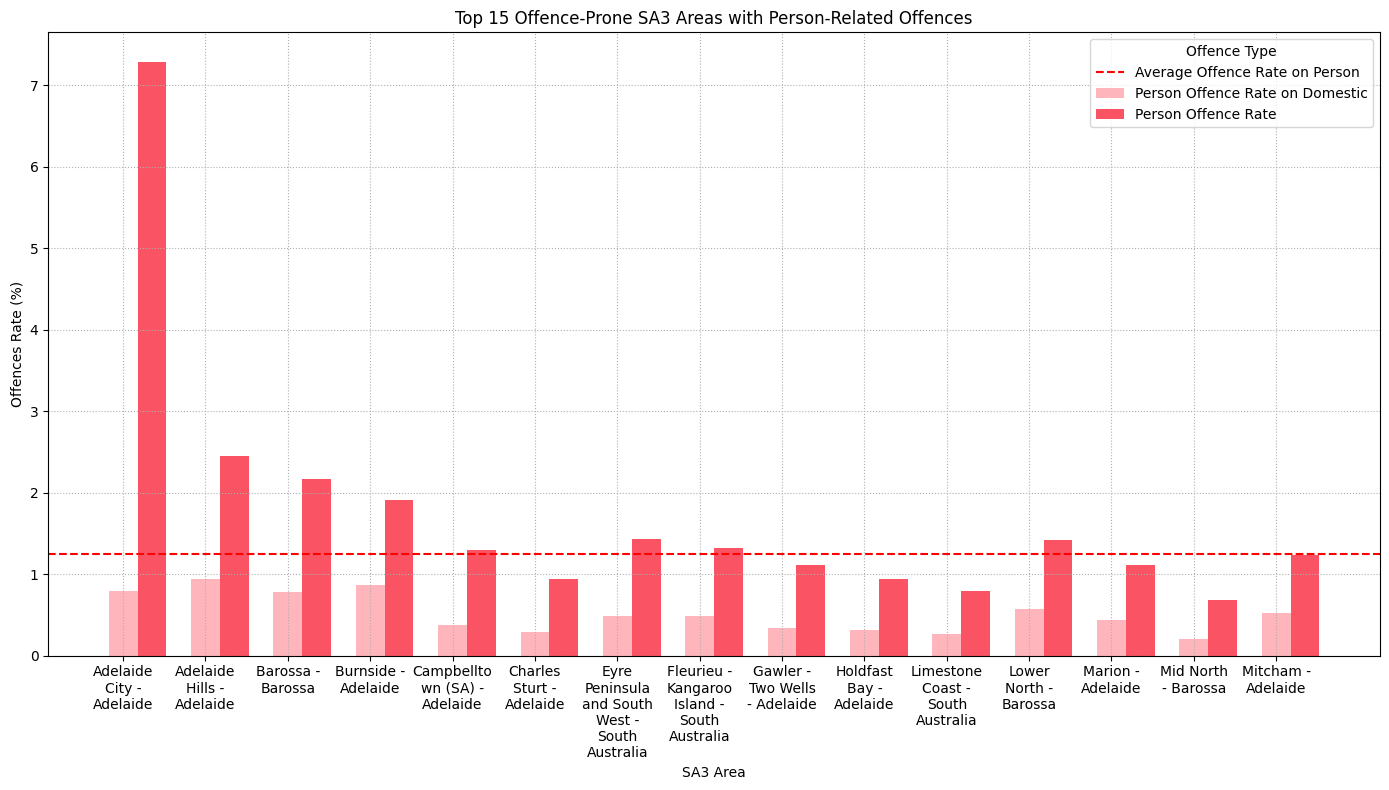

In [29]:
import textwrap
plt.figure(figsize=(12, 8))

bar_width = 0.35
average_offence_rate = df_gb_annual['Person Offence Rate'].mean()*100
# Define the positions of the bars
r1 = np.arange(len(df_gb_annual['SA3_name_2021'][:15]))
r2 = [x + bar_width for x in r1]
plt.figure(figsize=(14, 8))
plt.bar(r1, df_gb_annual['Person Offence Rate - Domestic'][:15]*100, color="#feb5bc", label='Person Offence Rate on Domestic', width=bar_width)
#plt.bar(r1, df_no_ade_pro_gb_annual['Property Offence Rate'], color="#8DD7F4", label='Property Offence Rate on Domestic', bottom=df_no_ade_pro_gb_annual['Person Offence Rate'], width=bar_width)


plt.bar(r2, df_gb_annual['Person Offence Rate'][:15]*100, color="#F95364", label='Person Offence Rate', width=bar_width)
#plt.bar(r2, df_no_ade_pro_sa_gb_annual['Property Offence Rate'], color="#38B5E6", label='Property Offence Rate', bottom=df_no_ade_pro_sa_gb_annual['Person Offence Rate'], width=bar_width)

plt.axhline(y=average_offence_rate, color='r', linestyle='--', label="Average Offence Rate on Person")

plt.title('Top 15 Offence-Prone SA3 Areas with Person-Related Offences')
plt.xlabel('SA3 Area')
plt.ylabel('Offences Rate (%)')

plt.legend(title='Offence Type')

# Show the plot
plt.grid(True, linestyle='dotted')

years = df_no_ade_pro_gb_annual['SA3_name_2021'].unique()[:15]

labels = [textwrap.fill(label, 10) for label in df_no_ade_pro_gb_annual['SA3_name_2021'][:15].astype(str)]
plt.xticks(ticks=range(len(years)), labels=labels)
plt.tight_layout()
plt.show()

Adelaide City again having the highest crime rate on person in South Australia. In top 15 area with highest crime rate, 9 of them from Adelaide and 4 out of 8 regions above the average line are from Adelaide.

With such significant data, we decide not to focus on Adelaide. Instead, we will try to understand the crime rate of the suburb all across South Australia

## 2. SELECT SUBURB

We will create an index to show which suburb has the highest crime rate, focusing on crime and crime rate

In [30]:
df_sa_check = df_sa_coord.copy()
gb_col = 'Suburb - Incident'
df_sa_check['Offence Level 1 property'] = (df_sa_check['Offence Level 1 Description']=='OFFENCES AGAINST PROPERTY')
df_sa_check['Offence Level 1 person'] = (df_sa_check['Offence Level 1 Description']=='OFFENCES AGAINST THE PERSON')
df_sa_check['Assault'] = df_sa_check['Offence Level 3 Description'].str.contains('Serious Assault')

# Group by suburb
df_sa_check_gb = df_sa_check.groupby(['Suburb - Incident']).agg({ 'Postcode - Incident':'first', 'Offence Count':'sum',  'Offence Level 1 property':'sum','Offence Level 1 person':'sum','Assault':'sum', 'Latitude':'first', 'Longitude':'first' }).reset_index()
df_sa_check_gb.head()

# Score based on the number of offences
df_sa_check_gb['Score'] =  df_sa_check_gb['Offence Level 1 property'] + df_sa_check_gb['Offence Level 1 person'] + df_sa_check_gb['Assault']

# Score based on the difference between person and property offences
df_sa_check_gb['person/property'] = df_sa_check_gb['Offence Level 1 person'] /(df_sa_check_gb['Offence Level 1 property']+1)
df_sa_check_gb['person/property'] = df_sa_check_gb['person/property'].clip(0, 1)
df_sa_check_gb['Score'] *= df_sa_check_gb['person/property']

# Score based on the number of assaults
df_sa_check_gb['assault/person'] = df_sa_check_gb['Assault'] /(df_sa_check_gb['Offence Level 1 person']+0.1)
df_sa_check_gb.sort_values(by='Score', ascending=False).head(20)

Suburb - Incident Postcode - Incident  Offence Count  \
2              ADELAIDE                5000        91594.0   
1430       PORT AUGUSTA                5700        23377.0   
1199      MURRAY BRIDGE                5253        21906.0   
1157      MOUNT GAMBIER                5290        23132.0   
1130      MORPHETT VALE                5162        23122.0   
1556          SALISBURY                5159        19832.0   
1922     WHYALLA STUART                5608        12770.0   
1445       PORT LINCOLN                5606        19983.0   
1560    SALISBURY NORTH                5108        11428.0   
520           ELIZABETH                5112        18922.0   
455        DAVOREN PARK                5113        14329.0   
330      CHRISTIE DOWNS                5164         9628.0   
1338  PARAFIELD GARDENS                5107        14198.0   
378         COOBER PEDY                5723         6514.0   
309              CEDUNA                5690         7152.0   
1339          PARALOWIE                5108        13767.0   
1920     WHYALLA NORRIE                5608        11925.0   
872             KILBURN                5084        11658.0   
521     ELIZABETH DOWNS                5113         8581.0   
526     ELIZABETH SOUTH                5112         8867.0   

      Offence Level 1 property  Offence Level 1 person  Assault   Latitude  \
2                        28343                   12675     4843 -34.928550   
1430                     12059                    4789     2656 -32.567930   
1199                     11909                    4456     2231 -35.117475   
1157                     12815                    4409     2028 -37.817000   
1130                     13453                    4072     1997 -35.112150   
1556                     11610                    3437     1566 -35.073400   
1922                      7264                    2902     1759 -33.022900   
1445                     11284                    3297     1620 -34.726600   
1560                      6957                    2662     1433 -34.760220   
520                      10421                    2907     1132 -34.736650   
455                       8908                    2726     1480 -34.698763   
330                       5793                    2412     1253 -35.130000   
1338                      9111                    2605     1389 -34.789050   
378                       3658                    1922     1332 -29.010300   
309                       4113                    1961     1273 -31.980683   
1339                      8815                    2450     1311 -34.760220   
1920                      7552                    2157     1147 -33.022900   
872                       7625                    2153     1146 -34.863800   
521                       5523                    1900     1098 -34.698763   
526                       5753                    1864     1031 -34.736650   

       Longitude         Score  person/property  assault/person  
2     138.600212  20508.332451         0.447185        0.382088  
1430  137.804530   7744.996352         0.397098        0.554593  
1199  139.330450   6957.495886         0.374139        0.500662  
1157  140.752900   6623.132647         0.344023        0.459958  
1130  138.541400   5908.546455         0.302661        0.490410  
1556  138.594125   4917.654035         0.296012        0.455617  
1922  137.530775   4763.434274         0.399449        0.606113  
1445  135.882900   4733.247408         0.292158        0.491341  
1560  138.624400   4228.287439         0.382581        0.538297  
520   138.671967   4033.316062         0.278929        0.389391  
455   138.674950   4012.657313         0.305983        0.542900  
330   138.495900   3937.296514         0.416293        0.519464  
1338  138.607900   3746.545764         0.285887        0.533185  
378   134.757500   3630.736267         0.525280        0.692992  
309   133.251317   3502.058094         0.476665        0.649125  
1339  13

Try to map down the top places

I will select these suburb for analysis, mainly because it has high score from the above analysis and they represent different parts of SA
 - PORT AUGUSTA
 - MOUNT GAMBIER
 - CEDUNA
 - COOBER PEDY
 - MURRAY BRIDGE
 - MORPHETT VALE
 - PORT LINCOLN
 - WHYALLA NORRIE

We do select a suburb that on the far East of Adelaide, since we do want to understand the suburb around Adelaide that not in the urbanization zone

In [31]:
SELECTED_SUBURBS = ['PORT AUGUSTA', 'MOUNT GAMBIER', 'CEDUNA', 'COOBER PEDY', 'MURRAY BRIDGE', 'MORPHETT VALE', 'PORT LINCOLN','WHYALLA NORRIE' ]
df_select = df_sa_check_gb[df_sa_check_gb['Suburb - Incident'].isin(SELECTED_SUBURBS)].sort_values(by='Score', ascending=False)

Pin the selected part into the map

In [32]:
# Assign colors based on score ranking
color_mapping = ['red'] * 2 + ['orange'] * 3 + ['green'] * 3
df_select['color'] = color_mapping  # Add the colors to the DataFrame

# Initialize the map
m = folium.Map(location=[-30.000233, 136.209152], zoom_start=6)

# Add markers with assigned colors
for i, row in df_select.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Suburb - Incident'],
        icon=folium.Icon(color=row['color'])
    ).add_to(m)

# Save and display the map
m.save('crime_hotspots.html')
m

Collect the population data online

In [33]:
population = [14500, 22900, 27801,24606, 15018, 1500, 3717, 6609]
df_select['Population'] = population

In [34]:
df_select['Crime Rate'] = df_select['Offence Count'] / df_select['Population']
df_select['Assault Rate'] = df_select['Assault'] / df_select['Population']
df_select = df_select.sort_values(by='Crime Rate', ascending=False)
df_select['Crime Rate'] /= 14
df_select['Assault Rate'] /= 14
df_select

Suburb - Incident Postcode - Incident  Offence Count  \
378        COOBER PEDY                5723         6514.0   
309             CEDUNA                5690         7152.0   
1920    WHYALLA NORRIE                5608        11925.0   
1430      PORT AUGUSTA                5700        23377.0   
1445      PORT LINCOLN                5606        19983.0   
1199     MURRAY BRIDGE                5253        21906.0   
1130     MORPHETT VALE                5162        23122.0   
1157     MOUNT GAMBIER                5290        23132.0   

      Offence Level 1 property  Offence Level 1 person  Assault   Latitude  \
378                       3658                    1922     1332 -29.010300   
309                       4113                    1961     1273 -31.980683   
1920                      7552                    2157     1147 -33.022900   
1430                     12059                    4789     2656 -32.567930   
1445                     11284                    3297     1620 -34.726600   
1199                     11909                    4456     2231 -35.117475   
1130                     13453                    4072     1997 -35.112150   
1157                     12815                    4409     2028 -37.817000   

       Longitude        Score  person/property  assault/person   color  \
378   134.757500  3630.736267         0.525280        0.692992   green   
309   133.251317  3502.058094         0.476665        0.649125   green   
1920  137.530775  3100.276976         0.285582        0.531732   green   
1430  137.804530  7744.996352         0.397098        0.554593     red   
1445  135.882900  4733.247408         0.292158        0.491341  orange   
1199  139.330450  6957.495886         0.374139        0.500662     red   
1130  138.541400  5908.546455         0.302661        0.490410  orange   
1157  140.752900  6623.132647         0.344023        0.459958  orange   

      Population  Crime Rate  Assault Rate  
378         1500    0.310190      0.063429  
309         3717    0.137438      0.024463  
1920        6609    0.128883      0.012397  
1430       14500    0.115158      0.013084  
1445       15018    0.095043      0.007705  
1199       22900    0.068328      0.006959  
1130       24606    0.067121      0.005797  
1157       27801    0.059433      0.005211

In [35]:
LOW_CRIME_SUBURBS = ['MOUNT GAMBIER', 'MURRAY BRIDGE', 'MORPHETT VALE']
MIDDLE_CRIME_SUBURBS = ['PORT AUGUSTA', 'PORT LINCOLN','WHYALLA NORRIE']
HIGH_CRIME_SUBURBS = ['CEDUNA', 'COOBER PEDY', ]

In [36]:
df_sa_low_crime = df_sa[df_sa['Suburb - Incident'].isin(LOW_CRIME_SUBURBS)]
df_sa_mid_crime = df_sa[df_sa['Suburb - Incident'].isin(MIDDLE_CRIME_SUBURBS)]
df_sa_high_crime = df_sa[df_sa['Suburb - Incident'].isin(HIGH_CRIME_SUBURBS)]

We will divide the suburb into 3 main group:
- Low_crime_rate: MOUNT GAMBIER, MURRAY BRIDGE, MORPHETT VALE
- Medium crime rate: WHYALLA NORRIE, PORT AUGUSTA, PORT LINCOLN
- High crime rate: CEDUNA, COOBER PEDY

https://www.abc.net.au/news/2021-11-25/coober-pedy-community-campaigns-against-domestic-violence/100649152
https://www.abc.net.au/news/2024-02-17/ceduna-crime-wave-after-cashless-debit-card-locals-want-jobs/103476386
https://www.canstar.com.au/home-insurance/state-hotspots-for-home-theft/

### BETTER REASON TO SPLIT
Here are the reason why we decise to group them into three different group

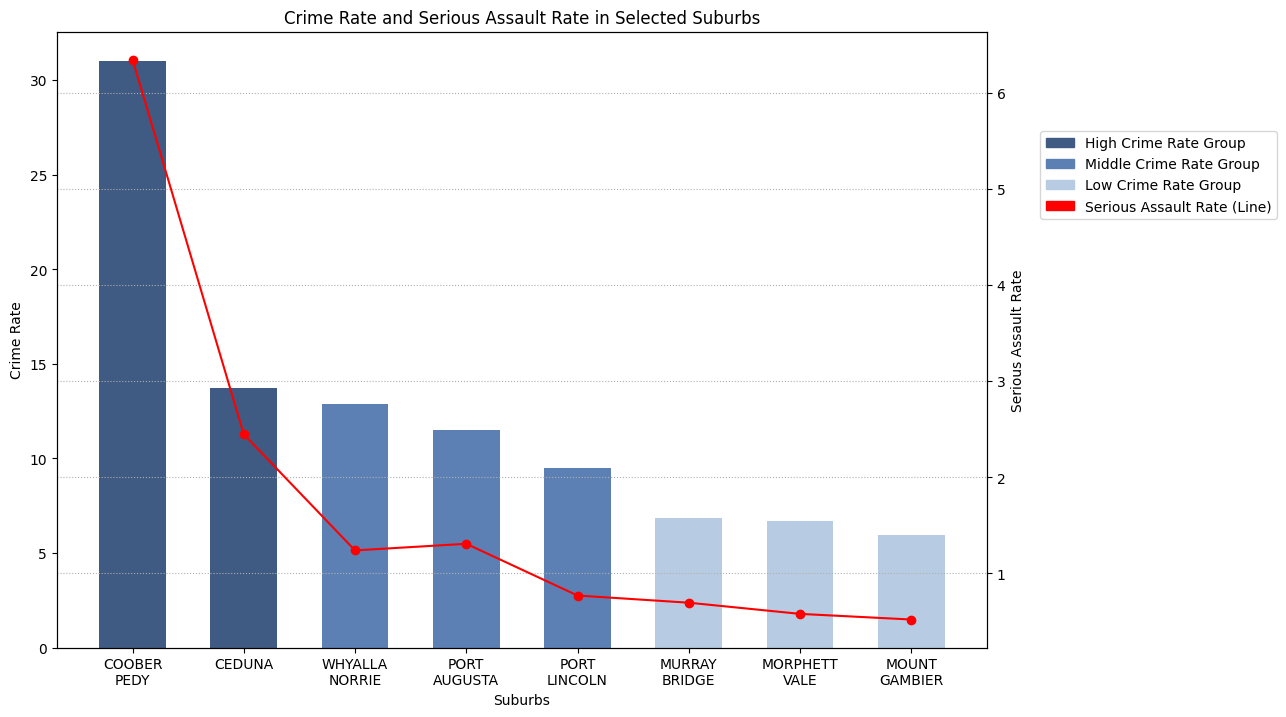

In [37]:
import matplotlib.pyplot as plt
import textwrap
import matplotlib.patches as mpatches

# Sample data
categories = df_select['Suburb - Incident']
bar_data = df_select['Crime Rate'] * 100
line_data = df_select['Assault Rate'] * 100

# Define specific colors based on the palette (3rd, 5th, and 7th colors)
bar_colors = ['#3F5A83'] * 2 + ['#5D80B4'] * 3 + ['#B7CCE2'] * 3  # Color 3, 5, 7

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot bar chart with selected palette colors
ax1.bar(categories, bar_data, color=bar_colors, label='Crime Rate', width=0.6)
ax1.set_xlabel('Suburbs')
ax1.set_ylabel('Crime Rate')
ax1.tick_params(axis='y')

# Plot line chart with red color
ax2 = ax1.twinx()
ax2.plot(categories, line_data, color='#FF0000', marker='o', label='Serious Assault Rate')  # Red line
ax2.set_ylabel('Serious Assault Rate')
ax2.tick_params(axis='y')

# Custom legend entries for the selected colors and red line
bar_legend_first = mpatches.Patch(color='#3F5A83', label='High Crime Rate Group')
bar_legend_second = mpatches.Patch(color='#5D80B4', label='Middle Crime Rate Group')
bar_legend_third = mpatches.Patch(color='#B7CCE2', label='Low Crime Rate Group')
line_legend = mpatches.Patch(color='#FF0000', label='Serious Assault Rate (Line)')

# Show customized legend
plt.legend(handles=[bar_legend_first, bar_legend_second, bar_legend_third, line_legend],
           loc="upper left", bbox_to_anchor=(1.05, 0.85))

# Wrap and adjust x-axis labels
labels = [textwrap.fill(label, 10) for label in categories]
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.title('Crime Rate and Serious Assault Rate in Selected Suburbs')
plt.grid(True, linestyle='dotted')
plt.show()


Here you can clearly see that COOBER PEDY and CEDUNA has a higher crime rate and assault rate than the rest, so it should be on cluster **High Crime Rate Suburb**. WHYALLA NORRIE, PORT AUGUSTA and PORT LINCOLN has value around median rate, so it should be on **Medium Crime Rate Suburb**, and the rest are in **Low Crime Rate Suburb**

Notice that all the **High Crime Rate Suburb** are in the North-West and far in the derest area of South Australia, all **Medium Crime Rate Suburb** where port or close to the sea near the Spencer Gulf, and the **Low Crime Rate Suburb** are in the East side of SA.

## 3. Analyze the distribution of crimes in suburb

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def property_analysis_compare(df_sa, note='', color_palette='Blues'):
    # Filter data for OFFENCES AGAINST PROPERTY
    suburbs = df_sa['Suburb - Incident'].unique()
    targets = ['THEFT AND RELATED OFFENCES', 'PROPERTY DAMAGE AND ENVIRONMENTAL']
    bar_width = 0.7/len(suburbs)
    filtered_data = df_sa[(df_sa['Offence Level 1 Description'] == 'OFFENCES AGAINST PROPERTY')]

    # Create a new column for four-year periods
    filtered_data['Four_Year_Period'] = ((filtered_data['Start Fiscal Year']) // 4 ) * 4
    # print(filtered_data[['Four_Year_Period', 'Start Fiscal Year']].drop_duplicates())

    # Group by 'Two_Year_Period' and 'Offence Level 2 Description' and calculate the total offences
    four_year_sum = filtered_data.groupby(['Suburb - Incident','Four_Year_Period', 'Offence Level 2 Description'])['Offence Count'].sum().reset_index()
    four_year_sum['Four_Year_Period'] = four_year_sum['Four_Year_Period'].astype(int)
    four_year_sum['Four_Year_Period'] = (four_year_sum['Four_Year_Period']).astype(str) + '/' + (four_year_sum['Four_Year_Period'] + 4).astype(str)
    # Normalize to get percentages
    four_year_sum['Percentage'] = four_year_sum.groupby(['Suburb - Incident','Four_Year_Period'])['Offence Count'].transform(lambda x: x / x.sum() * 100)

    red_palette = sns.color_palette(color_palette, n_colors=len(four_year_sum['Suburb - Incident'].unique()))[::-1]
    sns.set_palette(red_palette)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    plt.suptitle(f'Percentage in OFFENCES AGAINST PERSON {note} (2010-2024)')
    for i,target in enumerate(targets):
        r = np.arange(4)
        r1 = [x - ((len(suburbs)+1)/2)*bar_width for x in r]

        for suburb in suburbs:
            r1 = [x + bar_width for x in r1]
            four_year_sum_suburb = four_year_sum[(four_year_sum['Suburb - Incident'] == suburb) & (four_year_sum['Offence Level 2 Description'] == target)]
            # Create a monotone red palette


            # Plot the 100% stacked bar chart for four-year periods
            axes[i].bar(r1, four_year_sum_suburb['Percentage'], width=bar_width, edgecolor='white', label=suburb)

        if i == 0:
            axes[i].legend(title='Suburbs', loc='upper left')


        axes[i].set_ylabel(f'Total Percentage of OFFENCES AGAINST THE PERSON')
        axes[i].set_xlabel('Four_Year_Period')
        axes[i].set_title(f'{target}')
        labels = ['2010/2012', '2012/2016', '2016/2020', '2020/2024']
        # Add dotted horizontal grid lines behind bars
        axes[i].set_xticks(ticks=range(len(labels)), labels=labels)  # Ensure x-axis labels are four-year periods
        axes[i].grid(axis='y', linestyle=':', linewidth=0.7, zorder=0)


# property_analysis_compare(df_sa_mid_crime, color_palette='Greens')

In [39]:
def person_analysis_compare(df_sa, note='', color_palette='rocket'):
    # Filter data for OFFENCES AGAINST PROPERTY
    suburbs = df_sa['Suburb - Incident'].unique()
    targets = ['Serious Assault resulting in injury', 'Serious Assault not resulting in injury']
    bar_width = 0.5/len(suburbs)
    filtered_data = df_sa[(df_sa['Offence Level 1 Description'] == 'OFFENCES AGAINST THE PERSON')]

    # Create a new column for four-year periods
    filtered_data['Four_Year_Period'] = ((filtered_data['Start Fiscal Year']) // 4 ) * 4
    # print(filtered_data[['Four_Year_Period', 'Start Fiscal Year']].drop_duplicates())
    filtered_data['Serious Assault'] = filtered_data['Offence Level 3 Description'].str.contains('Serious Assault')
    filtered_data['Serious Assault'] = filtered_data['Serious Assault'].astype(int)
    filtered_data['Serious Assault'] *= filtered_data['Offence Count']

    # Group by 'Two_Year_Period' and 'Offence Level 2 Description' and calculate the total offences
    four_year_sum = filtered_data.groupby(['Suburb - Incident','Four_Year_Period', 'Offence Level 2 Description']).agg({'Offence Count':'sum', 'Serious Assault':'sum'}).reset_index()
    four_year_sum['Four_Year_Period'] = four_year_sum['Four_Year_Period'].astype(int)
    four_year_sum['Four_Year_Period'] = (four_year_sum['Four_Year_Period']).astype(str) + '/' + (four_year_sum['Four_Year_Period'] + 4).astype(str)
    # Normalize to get percentages
    four_year_sum['Percentage'] = four_year_sum.groupby(['Suburb - Incident','Four_Year_Period'])['Offence Count'].transform(lambda x: x / x.sum() * 100)
    four_year_sum['Serious Assault Rate'] = (four_year_sum['Serious Assault']/four_year_sum['Offence Count']) * four_year_sum['Percentage']
    four_year_sum_2 = four_year_sum[four_year_sum['Offence Level 2 Description']=='ACTS INTENDED TO CAUSE INJURY']

    red_palette = sns.color_palette(color_palette, n_colors=len(four_year_sum['Suburb - Incident'].unique()))[::-1]
    plt.figure(figsize=(12, 8))
    sns.set_palette(red_palette)


    r = np.arange(4)
    r1 = [x - ((len(suburbs)+1)/2)*bar_width for x in r]
    plt.figure(figsize=(12, 8))
    for i,suburb in enumerate(suburbs):
        r1 = [x + bar_width for x in r1]

        four_year_sum_suburb = four_year_sum_2[(four_year_sum_2['Suburb - Incident'] == suburb)]
        plt.bar(r1, four_year_sum_suburb['Serious Assault Rate'], label=suburb, width=bar_width, color=red_palette[i])
        plt.bar(r1, four_year_sum_suburb['Percentage']-four_year_sum_suburb['Serious Assault Rate'], bottom=four_year_sum_suburb['Serious Assault Rate'], width=bar_width, edgecolor='white',
                color=red_palette[i], alpha=0.3)

    plt.xlabel('Year')
    plt.ylabel(f'Total Percentage of OFFENCES AGAINST THE PERSON')
    plt.title(f'ACTS INTENDED TO CAUSE INJURY in CRIME ON THE PERSON {note} (Bold is Serious Assault Rate)')

    labels = ['2010/2012', '2012/2016', '2016/2020', '2020/2024']

    plt.xticks(ticks=range(len(labels)), labels=labels)  # Ensure x-axis labels are four-year periods

    plt.legend(loc='upper left')
    plt.grid(True, linestyle='dotted')
    plt.show()


    # Group by 'Two_Year_Period' and 'Offence Level 2 Description' and calculate the total offences
    four_year_sum4 = filtered_data.groupby(['Suburb - Incident','Four_Year_Period', 'Offence Level 3 Description'])['Offence Count'].sum().reset_index()
    four_year_sum4['Four_Year_Period'] = four_year_sum4['Four_Year_Period'].astype(int)
    four_year_sum4['Four_Year_Period'] = (four_year_sum4['Four_Year_Period']).astype(str) + '/' + (four_year_sum4['Four_Year_Period'] + 4).astype(str)
    # Normalize to get percentages
    four_year_sum4['Percentage'] = four_year_sum4.groupby(['Suburb - Incident','Four_Year_Period'])['Offence Count'].transform(lambda x: x / x.sum() * 100)

    red_palette = sns.color_palette(color_palette, n_colors=len(four_year_sum4['Suburb - Incident'].unique()))[::-1]
    sns.set_palette(red_palette)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    plt.suptitle(f'Percentage in OFFENCES AGAINST THE PERSON {note} (2010-2024)')
    for i,target in enumerate(targets):
        r = np.arange(4)
        r1 = [x - ((len(suburbs)+1)/2)*bar_width for x in r]

        # plt.figure(figsize=(12, 8))

        for suburb in suburbs:
            r1 = [x + bar_width for x in r1]
            four_year_sum_suburb = four_year_sum4[(four_year_sum4['Suburb - Incident'] == suburb) & (four_year_sum4['Offence Level 3 Description'] == target)]
            # Create a monotone red palette


            # Plot the 100% stacked bar chart for four-year periods
            axes[i].bar(r1, four_year_sum_suburb['Percentage'], width=bar_width, edgecolor='white', label=suburb)

        if i == 0:
            axes[i].legend(title='Suburbs', loc='upper left')


        axes[i].set_ylabel(f'Total Percentage of OFFENCES AGAINST THE PERSON')
        axes[i].set_xlabel('Four_Year_Period')
        axes[i].set_title(f'{target}')
        labels = ['2010/2012', '2012/2016', '2016/2020', '2020/2024']
        # Add dotted horizontal grid lines behind bars
        axes[i].set_xticks(ticks=range(len(labels)), labels=labels)  # Ensure x-axis labels are four-year periods
        # plt.xticks(ticks=four_year_pivot.index, labels=[f'{year}-{year+1}' for year in four_year_pivot.index.astype(int)])  # Ensure x-axis labels are four-year periods
        axes[i].grid(axis='y', linestyle=':', linewidth=0.7, zorder=0)


    plt.show()


# person_analysis_compare(df_sa_low_crime, note='of Low Crime Rate', color_palette='rocket')
# person_analysis_compare(df_sa_mid_crime, note='of Middle Crime Rate', color_palette='flare')
# person_analysis_compare(df_sa_high_crime, note='of High Crime Rate', color_palette='magma')

### LOW CRIME RATE SUBURB

#### Property

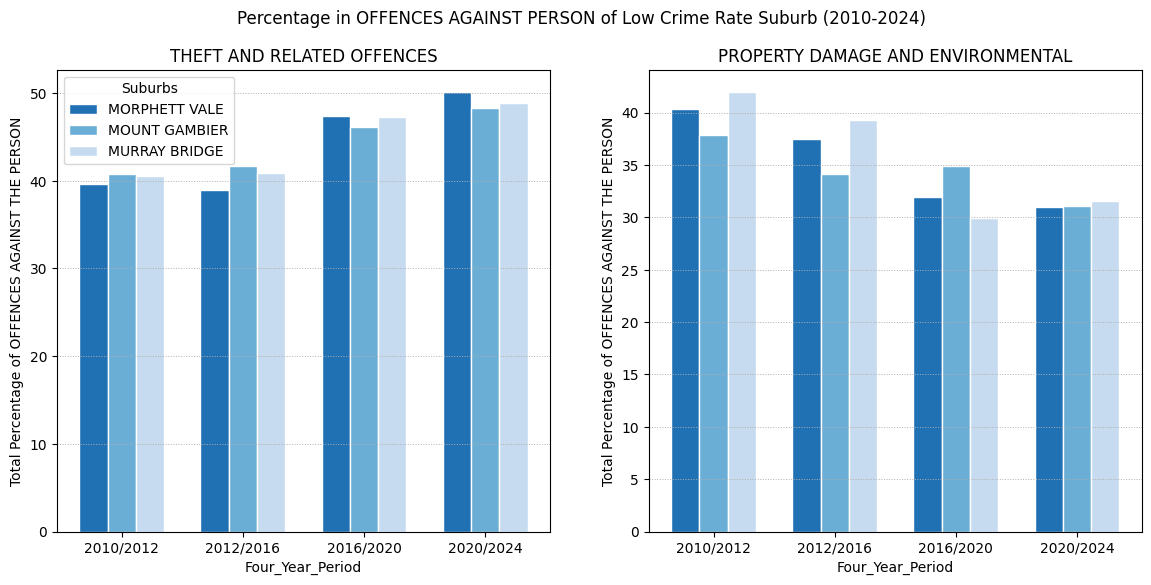

In [40]:
property_analysis_compare(df_sa_low_crime, note='of Low Crime Rate Suburb', color_palette='Blues')

In low-crime suburb, the distribution in 3 suburb are relatively similar. In addition, during recorded time, proportion of property damage decrease and the number for theft increase

Cite some paper/article here

### On person

<Figure size 1200x800 with 0 Axes>

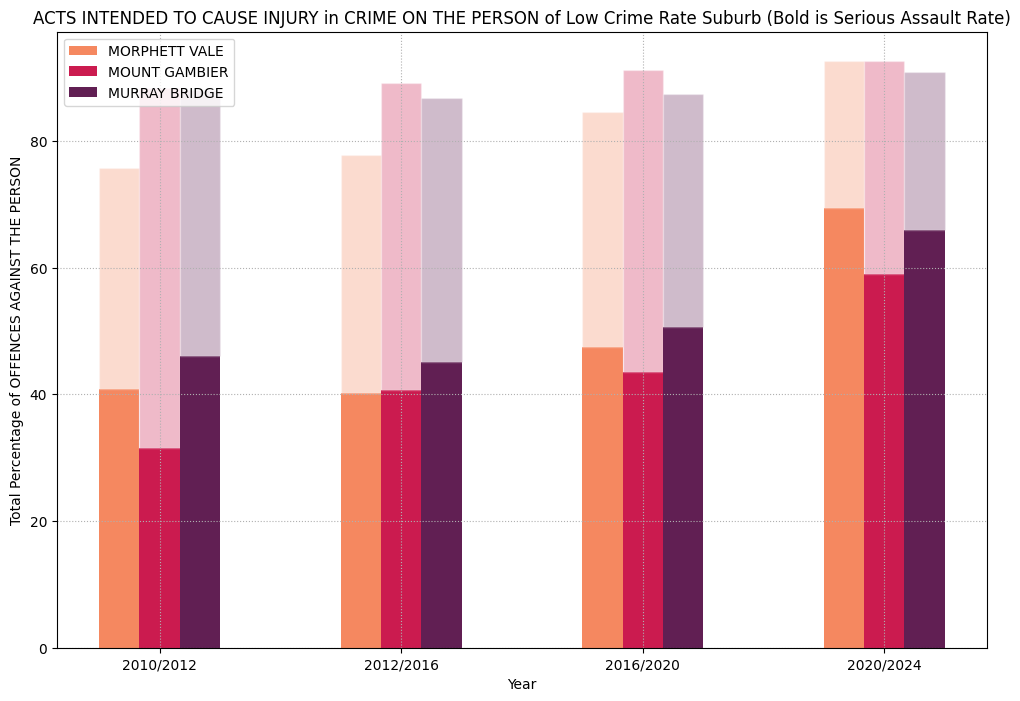

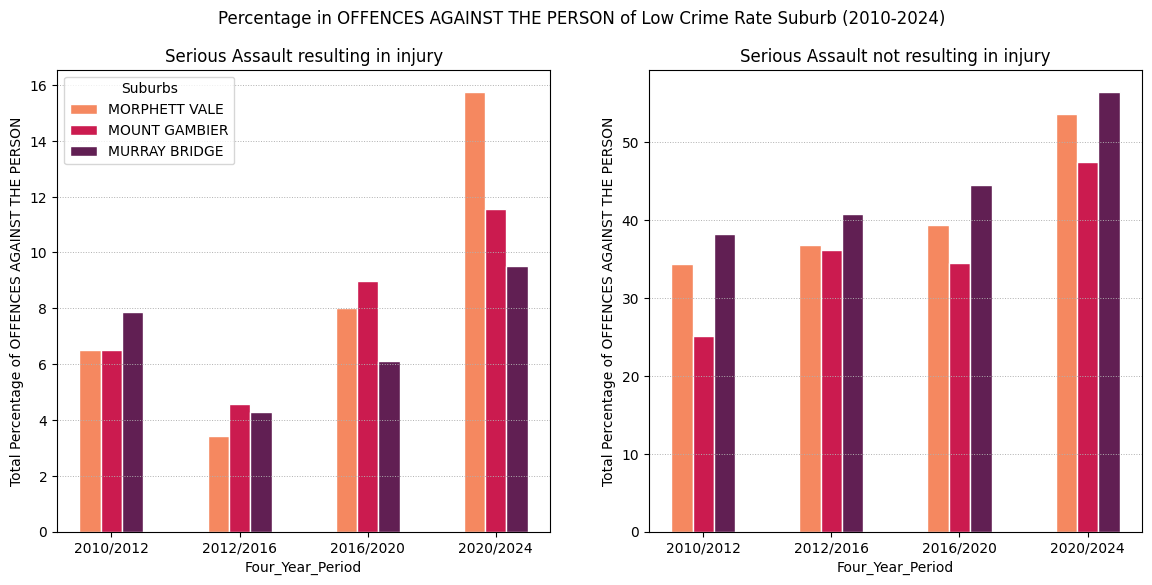

In [41]:
person_analysis_compare(df_sa_low_crime, note='of Low Crime Rate Suburb', color_palette='rocket')

Percentage of acts intend to cause injury for MOUNT GAMBIER and MURRAY BRIDGE remain stable, and only MORPHETT VALE's was increasing. However, we can see a trend of Serious Assault start to take over all the cases of total assault crime.

Serious Assault that lead to injury in all suburb has risen over the year. MOUNT VALE data has stood out and peek at nearly 16% of total crime on the person

cite some new here

On Serious not Assaulting, all increase

### MIDDLE CRIME RATE SUBURB

#### Property

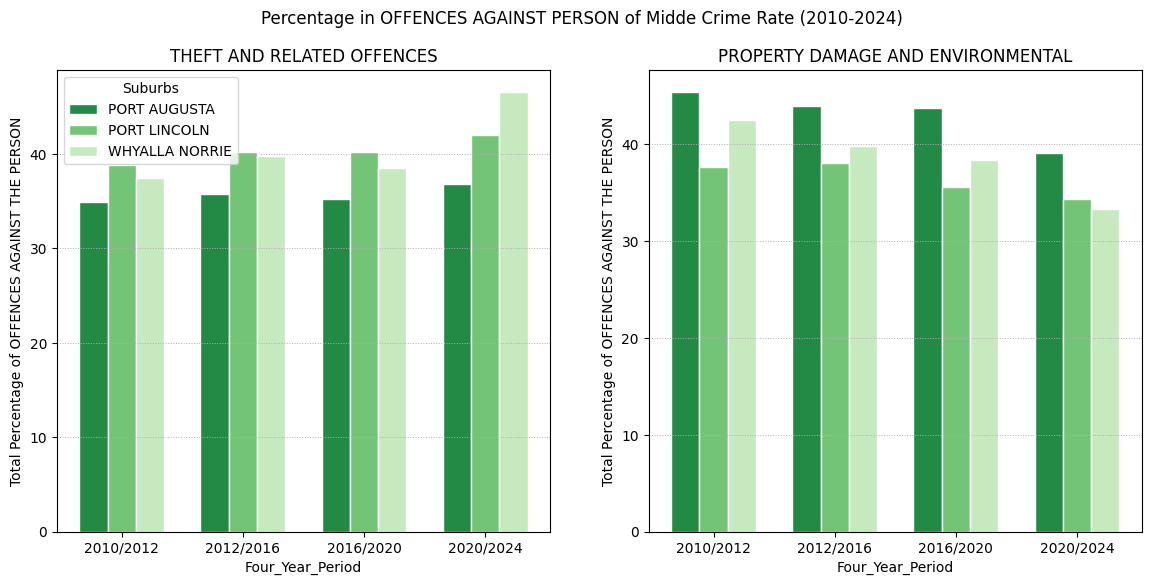

In [42]:
property_analysis_compare(df_sa_mid_crime, note='of Midde Crime Rate', color_palette='Greens')

There is not much different between suburbs and time. PORT AUGUSTA had lower theft rate but higher in property damaged

#### On person

<Figure size 1200x800 with 0 Axes>

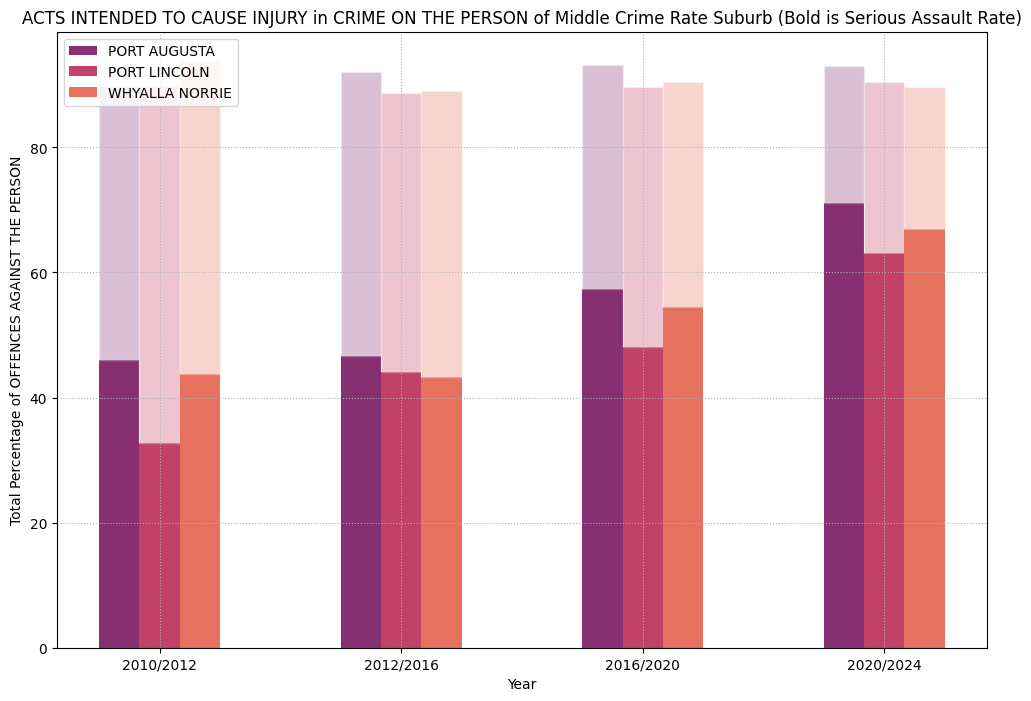

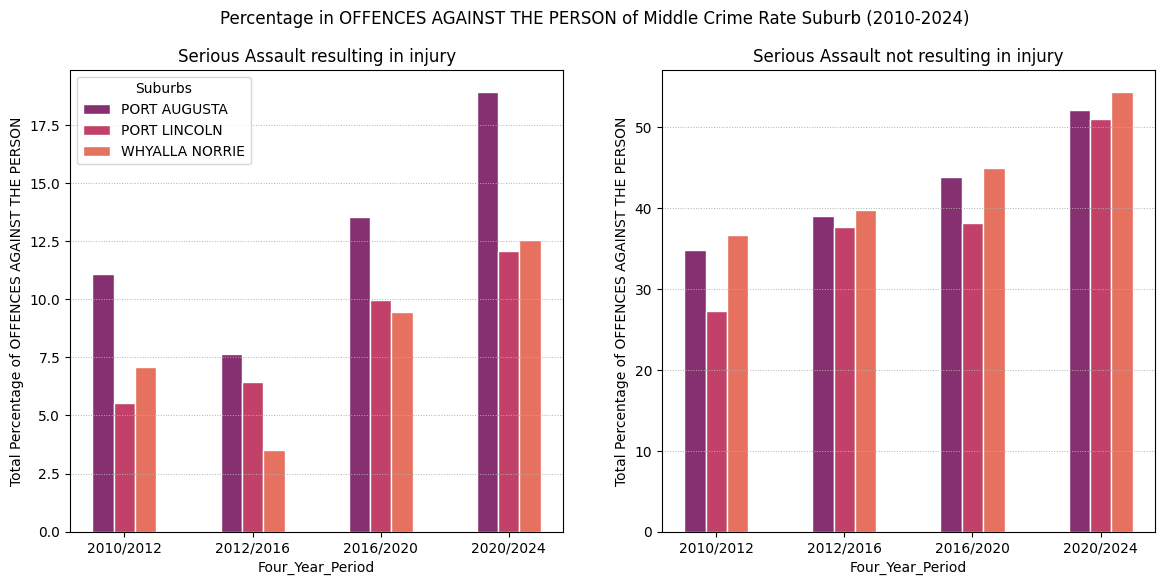

In [43]:
person_analysis_compare(df_sa_mid_crime, note='of Middle Crime Rate Suburb', color_palette='flare')


Again we can see the similar trend that although proportion of assault crime did not change overtime, the proportion of Serious Assault has increase significantly.

Port AUGUSTA often has 20-40% higher Injured crime rate

cite some paper here

### High Crime Rate
These suburb are on located area, in the North-East side of SA and far into the desert.

#### Property

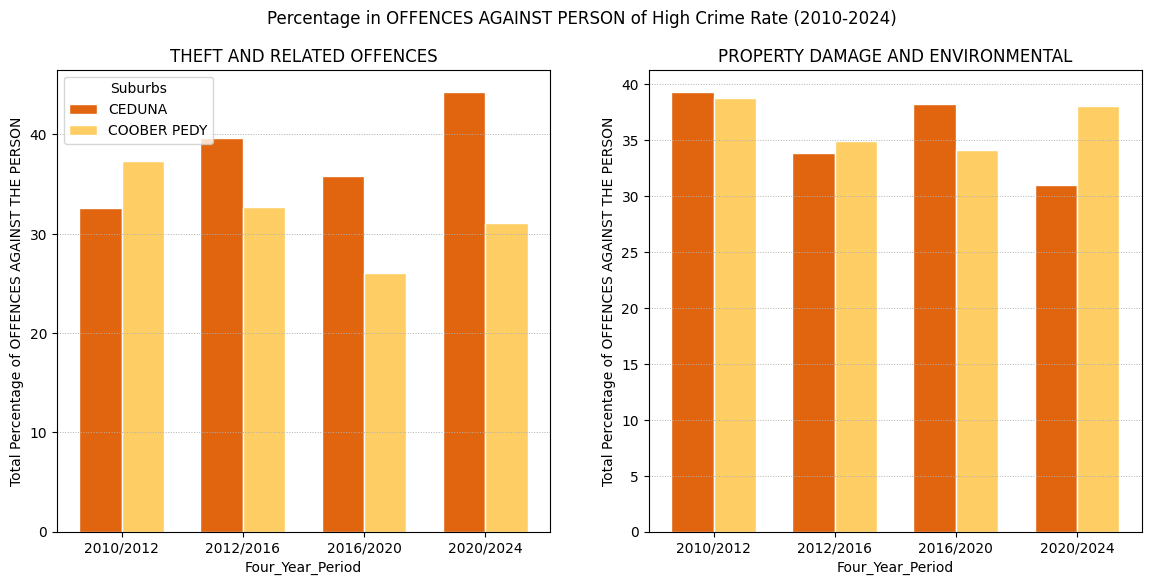

In [44]:
property_analysis_compare(df_sa_high_crime, note='of High Crime Rate', color_palette='YlOrBr')

CEDUNA has higher theft crime

#### On PERSON

<Figure size 1200x800 with 0 Axes>

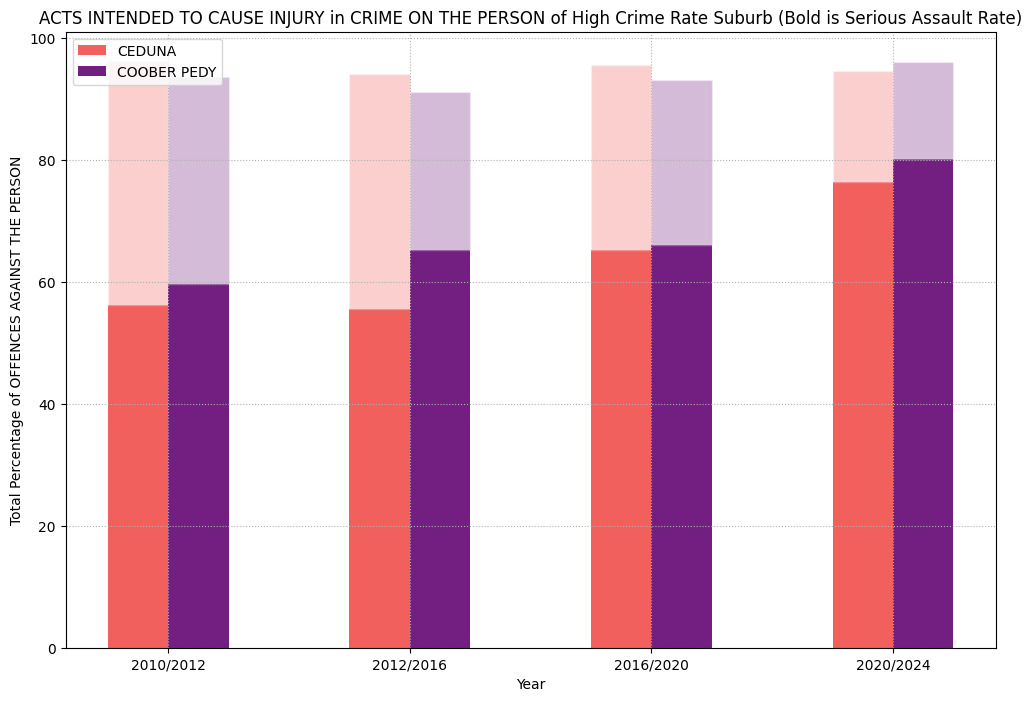

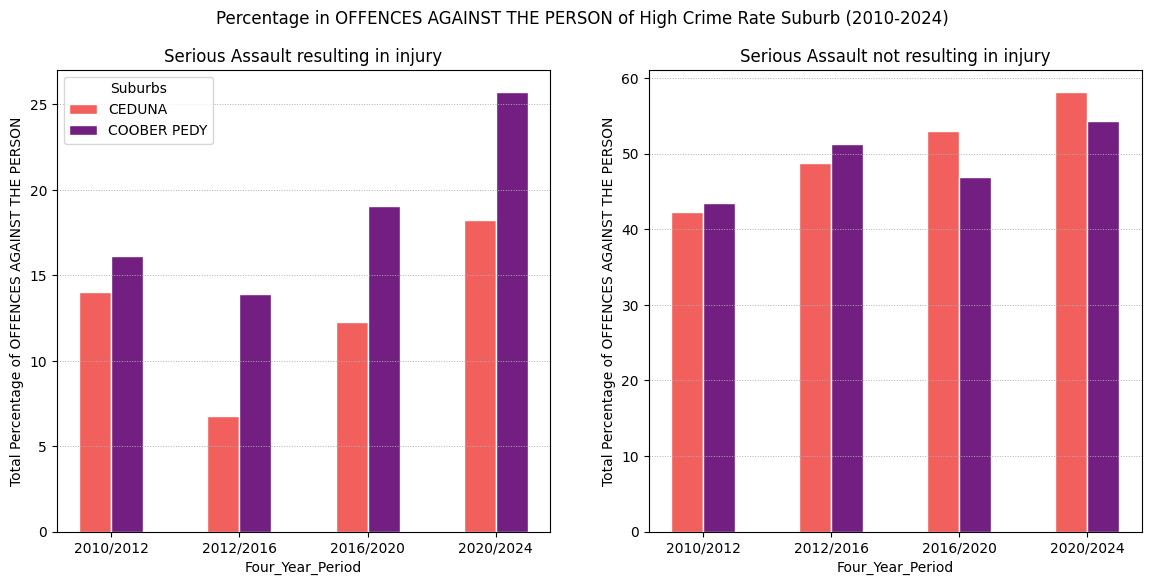

In [45]:
person_analysis_compare(df_sa_high_crime, note='of High Crime Rate Suburb', color_palette='magma')

The data also follow the same trend, but the number are much higher.

Coober Pedy has significantly higher data than ceduna

In serious assault that lead to injury, the highest data was 26% for COOBER PEDY, 160% higher than the highest data in low crime rate urban ,

## Cross Suburb Analysis

### Picking representation

I will choose CEDUNA, PORT AUGUSTA and MOUNT GAMBIER as a representation for 3 suburb in 3 different area

In [46]:
SELECTED_GENERAL_SUBURBS = ['CEDUNA', 'PORT LINCOLN', 'MOUNT GAMBIER']

df_sa_general_crime = df_sa[df_sa['Suburb - Incident'].isin(SELECTED_GENERAL_SUBURBS)]


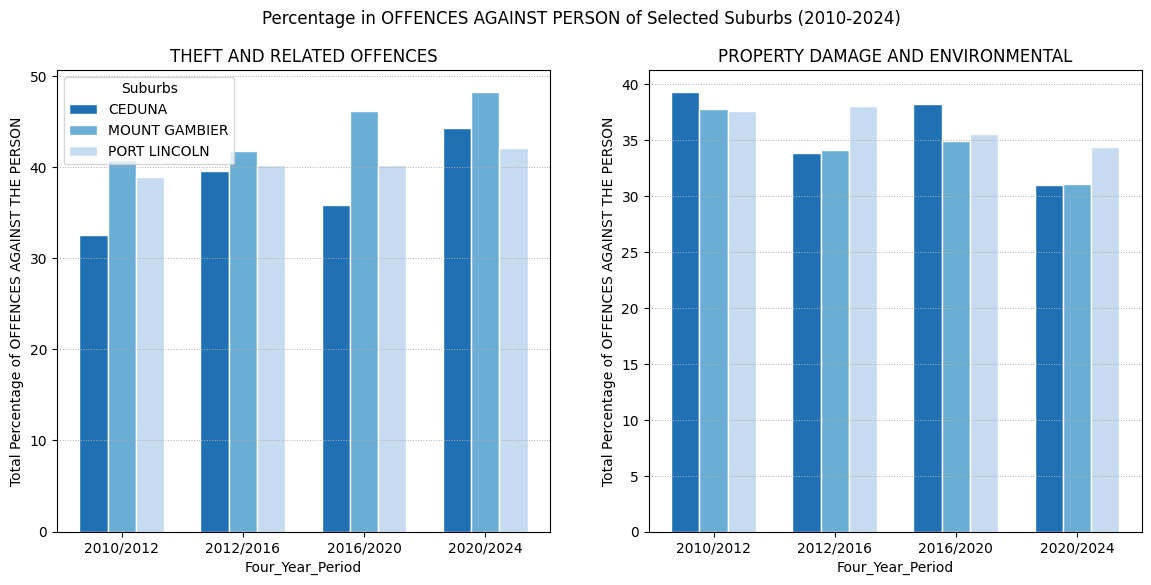

In [47]:
property_analysis_compare(df_sa_general_crime, note='of Selected Suburbs', color_palette='Blues')

<Figure size 1200x800 with 0 Axes>

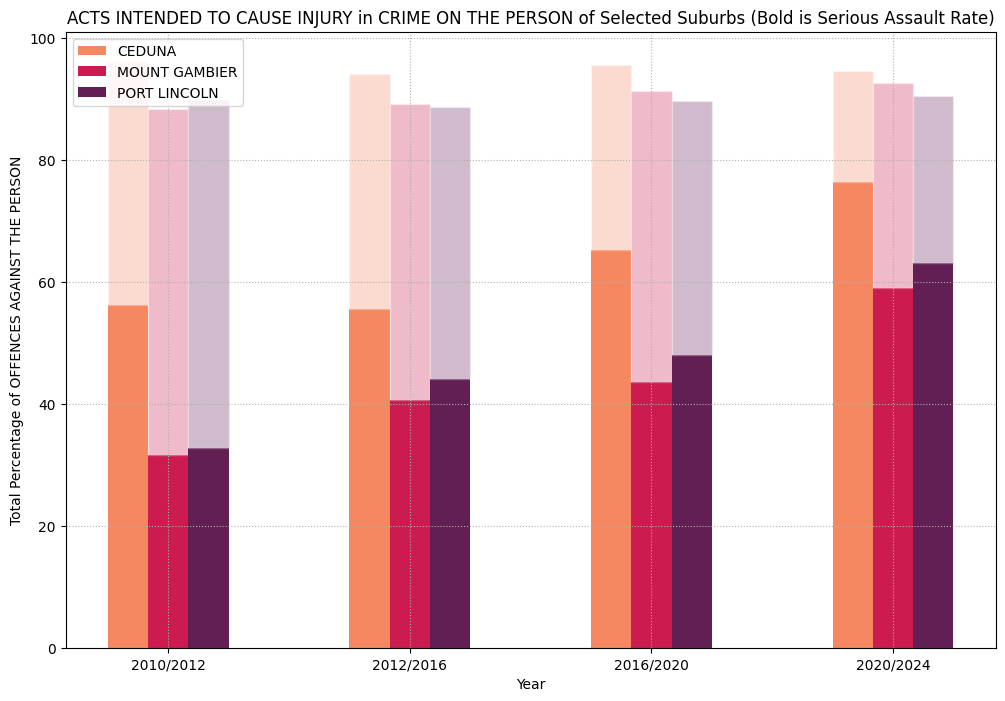

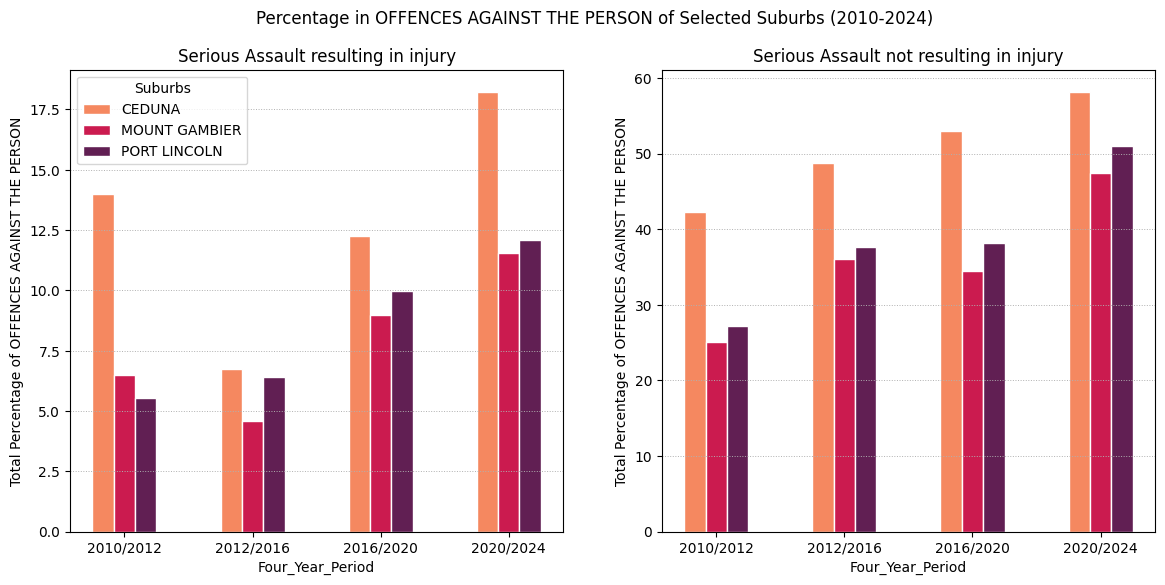

In [48]:
person_analysis_compare(df_sa_general_crime, note='of Selected Suburbs', color_palette='rocket')

When making comparison between 3 suburb from three main groups, we can see that they share quite similar proportion on Offence against property, specialy the incease in Theft Rate and the decline Property Damage. Interestingly, Mount Gambier has the highest data for Theft while Ceduna has the lowest.

The big diffence is on the crime rate, when CEDUNA's proportion for Serious Assault, both injury and non injury are way higher, at around 15-40% higher than 2 other suburbs.  

## 4. Cross Data with family Domestic Violence

Notice that this data is a separated dataset, so we must stack it on top of our current dataset

In [49]:
map_postcode = {
    "5700": "PORT AUGUSTA",
    "5290": "MOUNT GAMBIER",
    "5291": "MOUNT GAMBIER",
    "5690": "CEDUNA",
    "5723": "COOBER PEDY",
    "5162": "MORPHETT VALE",
    "5164": "MORPHETT VALE",
    "5253": "MURRAY BRIDGE",
    "5606": "PORT LINCOLN",
    "5616": "PORT LINCOLN",
    "5608": "WHYALLA NORRIE"
}
def map_postcode_to_suburb(postcode):
    return map_postcode.get(postcode, 'OTHER')

In [50]:
df_fam['Suburb - Incident'] = df_fam['Postcode - Incident'].apply(map_postcode_to_suburb)
df_fam_selected = df_fam[df_fam['Suburb - Incident'].isin(SELECTED_GENERAL_SUBURBS)]
df_fam_selected.head()

Financial Quarter And Year Name - Reported Postcode - Incident  \
593                               Q1-2021/2022                5290   
594                               Q1-2021/2022                5290   
595                               Q1-2021/2022                5290   
596                               Q1-2021/2022                5290   
597                               Q1-2021/2022                5290   

     Offence Level 1 Description        Offence Level 2 Description  \
593    OFFENCES AGAINST PROPERTY  PROPERTY DAMAGE AND ENVIRONMENTAL   
594    OFFENCES AGAINST PROPERTY          SERIOUS CRIMINAL TRESPASS   
595    OFFENCES AGAINST PROPERTY          SERIOUS CRIMINAL TRESPASS   
596    OFFENCES AGAINST PROPERTY         THEFT AND RELATED OFFENCES   
597  OFFENCES AGAINST THE PERSON      ACTS INTENDED TO CAUSE INJURY   

                 Offence Level 3 Description  Offence Count  Quarter  \
593  Other property damage and environmental           12.0        1   
594         Other unlawful entry with intent            1.0        1   
595                          SCT - Residence            1.0        1   
596                              Other theft            3.0        1   
597                           Common Assault            4.0        1   

          Year  Start Year Suburb - Incident  
593  2021/2022        2021     MOUNT GAMBIER  
594  2021/2022        2021     MOUNT GAMBIER  
595  2021/2022        2021     MOUNT GAMBIER  
596  2021/2022        2021     MOUNT GAMBIER  
597  2021/2022        2021     MOUNT GAMBIER

In [51]:
df_fam_low_crime = df_fam[df_fam['Suburb - Incident'].isin(LOW_CRIME_SUBURBS)]
df_fam_mid_crime = df_fam[df_fam['Suburb - Incident'].isin(MIDDLE_CRIME_SUBURBS)]
df_fam_high_crime = df_fam[df_fam['Suburb - Incident'].isin(HIGH_CRIME_SUBURBS)]

In [52]:
filtered_data = df_sa
filtered_data['Four_Year_Period'] = ((filtered_data['Start Fiscal Year']) // 4 ) * 4
four_year_sum = filtered_data.groupby(['Suburb - Incident','Four_Year_Period'])['Offence Count'].sum().reset_index()
four_year_sum['Four_Year_Period'] = four_year_sum['Four_Year_Period'].astype(int)
four_year_sum['Four_Year_Period'] = (four_year_sum['Four_Year_Period']).astype(str)


four_year_sum.head()

Suburb - Incident Four_Year_Period  Offence Count
0    ABERFOYLE PARK             2008          906.0
1    ABERFOYLE PARK             2012         1447.0
2    ABERFOYLE PARK             2016         1106.0
3    ABERFOYLE PARK             2020         1173.0
4      ACACIA RIDGE             2020            1.0

#### Resplit
For simple analysis, we will use only 2 group so-called good and bad suburb

In [53]:
FOUR_GOOD_SUBURBS = [ 'PORT LINCOLN', 'MOUNT GAMBIER', 'MURRAY BRIDGE','MORPHETT VALE',]
FOUR_BAD_SUBURBS = ['CEDUNA', 'COOBER PEDY', 'PORT AUGUSTA',  'WHYALLA NORRIE']
df_sa_good = df_sa[df_sa['Suburb - Incident'].isin(FOUR_GOOD_SUBURBS)]
df_fam_good = df_fam[df_fam['Suburb - Incident'].isin(FOUR_GOOD_SUBURBS)]

df_sa_bad = df_sa[df_sa['Suburb - Incident'].isin(FOUR_BAD_SUBURBS)]
df_fam_bad = df_fam[df_fam['Suburb - Incident'].isin(FOUR_BAD_SUBURBS)]

In [54]:
def analysis_domestic_simple_compare(df_sa, df_fam, note='', color_palette='Blues'):
    # Filter data for OFFENCES AGAINST PROPERTY
    suburbs = df_sa['Suburb - Incident'].unique()
    bar_width = 0.7/len(suburbs)

    filtered_data = df_sa
    filtered_data['Four_Year_Period'] = ((filtered_data['Start Fiscal Year']) // 4 ) * 4
    four_year_sum = filtered_data.groupby(['Suburb - Incident','Four_Year_Period'])['Offence Count'].sum().reset_index()
    four_year_sum['Four_Year_Period'] = four_year_sum['Four_Year_Period'].astype(int)
    four_year_sum['Four_Year_Period'] = (four_year_sum['Four_Year_Period']).astype(str) + '/' + (four_year_sum['Four_Year_Period'] + 4).astype(str)
    # Normalize to get percentages

    filtered_data2 = df_fam
    filtered_data2['Four_Year_Period'] = ((filtered_data2['Start Year']) // 4 ) * 4
    four_year_sum2 = filtered_data.groupby(['Suburb - Incident','Four_Year_Period'])['Offence Count'].sum().reset_index()
    four_year_sum2['Four_Year_Period'] = four_year_sum2['Four_Year_Period'].astype(int)
    four_year_sum2['Four_Year_Period'] = (four_year_sum2['Four_Year_Period']).astype(str) + '/' + (four_year_sum2['Four_Year_Period'] + 4).astype(str)

    merge_df = four_year_sum[['Suburb - Incident', 'Four_Year_Period', 'Offence Count']].rename(columns={'Offence Count':'General Offence Count'})
    four_year_sum2 = four_year_sum2.merge(merge_df, on=['Suburb - Incident', 'Four_Year_Period'], how='left')
    four_year_sum2['Total Offence Count'] = four_year_sum2['Offence Count'] + four_year_sum2['General Offence Count']

    red_palette = sns.color_palette(color_palette, n_colors=len(four_year_sum['Suburb - Incident'].unique()))[::-1]
    sns.set_palette(red_palette)


    r = np.arange(4)
    r1 = [x - ((len(suburbs)+1)/2)*bar_width for x in r]
    plt.figure(figsize=(12, 8))
    plt.title(f'Total offences From 2010 to 2024 (Bold is family and Domestic Violence)')
    for i, suburb in enumerate(suburbs):
        r1 = [x + bar_width for x in r1]
        four_year_sum_suburb = four_year_sum2[(four_year_sum2['Suburb - Incident'] == suburb)]
        # Create a monotone red palette


        # Plot the 100% stacked bar chart for four-year periods
        plt.bar(r1, four_year_sum_suburb['Offence Count'], width=bar_width,  label=suburb, color=red_palette[i])
        plt.bar(r1, four_year_sum_suburb['Total Offence Count'], bottom=four_year_sum_suburb['Offence Count'], width=bar_width, alpha=0.3, edgecolor='white', color=red_palette[i])



    plt.title(f'Total offences in {note} From 2010 to 2024 (Bold is Family and Domestic Violence)')
    plt.ylabel('Total Offences')
    plt.xlabel('Four_Year_Period')

    labels = ['2010/2012', '2012/2016', '2016/2020', '2020/2024']

    plt.xticks(ticks=range(len(labels)), labels=labels)  # Ensure x-axis labels are four-year periods
    # plt.xticks(ticks=four_year_pivot.index, labels=[f'{year}-{year+1}' for year in four_year_pivot.index.astype(int)])  # Ensure x-axis labels are four-year periods
    plt.legend( loc='upper right')
    plt.grid(axis='y', linestyle=':', linewidth=0.7, zorder=0)  # Add dotted horizontal grid lines behind bars
    plt.show()
# analysis_domestic_simple_compare(df_sa_good, df_fam_good, note='Low Crime Rate Suburb', color_palette='YlOrBr')

In [55]:
def person_analysis_compare(df_sa, df_fam, note='', color_palette='rocket'):
    # Filter data for OFFENCES AGAINST PROPERTY

    suburbs = df_sa['Suburb - Incident'].unique()

    bar_width = 0.5/len(suburbs)
    filtered_data = df_sa[(df_sa['Offence Level 1 Description'] == 'OFFENCES AGAINST THE PERSON')]

    # Create a new column for four-year periods
    filtered_data['Four_Year_Period'] = ((filtered_data['Start Fiscal Year']) // 4 ) * 4

    # Calculate the number of serious assaults using boolean mask
    filtered_data['Serious Assault'] = filtered_data['Offence Level 3 Description'].str.contains('Serious Assault')
    filtered_data['Serious Assault'] = filtered_data['Serious Assault'].astype(int)
    filtered_data['Serious Assault'] *= filtered_data['Offence Count']

    # Group by 'Two_Year_Period' and 'Offence Level 2 Description' and calculate the total offences
    four_year_sum = filtered_data.groupby(['Suburb - Incident','Four_Year_Period', 'Offence Level 2 Description']).agg({'Offence Count':'sum', 'Serious Assault':'sum'}).reset_index()
    four_year_sum['Four_Year_Period'] = four_year_sum['Four_Year_Period'].astype(int)
    four_year_sum['Four_Year_Period'] = (four_year_sum['Four_Year_Period']).astype(str) + '/' + (four_year_sum['Four_Year_Period'] + 4).astype(str)
    # Normalize to get percentages
    four_year_sum['Percentage'] = four_year_sum.groupby(['Suburb - Incident','Four_Year_Period'])['Offence Count'].transform(lambda x: x / x.sum() * 100)
    four_year_sum['Serious Assault Rate'] = (four_year_sum['Serious Assault']/four_year_sum['Offence Count']) * four_year_sum['Percentage']
    four_year_sum_2 = four_year_sum[four_year_sum['Offence Level 2 Description']=='ACTS INTENDED TO CAUSE INJURY']


    # Same for df_sa
    filtered_data2 = df_fam[(df_fam['Offence Level 1 Description'] == 'OFFENCES AGAINST THE PERSON')]
    filtered_data2['Four_Year_Period'] = ((filtered_data2['Start Year']) // 4 ) * 4
    filtered_data2['Serious Assault'] = filtered_data2['Offence Level 3 Description'].str.contains('Serious Assault')
    filtered_data2['Serious Assault'] = filtered_data2['Serious Assault'].astype(int)
    filtered_data2['Serious Assault'] *= filtered_data2['Offence Count']


    # Group by 'Two_Year_Period' and 'Offence Level 2 Description' and calculate the total offences
    four_year_sum2 = filtered_data2.groupby(['Suburb - Incident','Four_Year_Period', 'Offence Level 2 Description']).agg({'Offence Count':'sum', 'Serious Assault':'sum'}).reset_index()
    four_year_sum2['Four_Year_Period'] = four_year_sum2['Four_Year_Period'].astype(int)
    four_year_sum2['Four_Year_Period'] = (four_year_sum2['Four_Year_Period']).astype(str) + '/' + (four_year_sum2['Four_Year_Period'] + 4).astype(str)
    # Normalize to get percentages
    # four_year_sum2['Percentage'] = four_year_sum2.groupby(['Suburb - Incident','Four_Year_Period'])['Offence Count'].transform(lambda x: x / x.sum() * 100)
    four_year_sum_22 = four_year_sum2[four_year_sum2['Offence Level 2 Description']=='ACTS INTENDED TO CAUSE INJURY']
    merge_df = four_year_sum_2[['Suburb - Incident', 'Four_Year_Period', 'Offence Count', 'Serious Assault', 'Percentage', 'Serious Assault Rate']].rename(columns={'Offence Count':'General Offence Count', 'Serious Assault': 'General Serious Assault', 'Percentage':'General Percentage', 'Serious Assault Rate':'General Serious Assault Rate'})

    four_year_sum_22 = four_year_sum_22.merge(merge_df, on=['Suburb - Incident', 'Four_Year_Period'], how='left')
    four_year_sum_22['Total Offence Count'] = four_year_sum_22['Offence Count'] + four_year_sum_22['General Offence Count']


    four_year_sum_22['General Percentage'] = four_year_sum_22['General Offence Count'] / four_year_sum_22['Total Offence Count'] * four_year_sum_22['General Percentage']
    four_year_sum_22['General Serious Assault Rate'] = four_year_sum_22['General Serious Assault'] / four_year_sum_22['Total Offence Count'] * four_year_sum_22['General Serious Assault Rate']

    four_year_sum_22['Percentage'] = four_year_sum_22['Offence Count'] / four_year_sum_22['General Offence Count'] * four_year_sum_22['General Percentage']
    four_year_sum_22['Serious Assault Rate'] = four_year_sum_22['Serious Assault'] / four_year_sum_22['General Offence Count'] * four_year_sum_22['General Percentage']

    four_year_sum_22['Total Percentage'] = four_year_sum_22['Percentage'] + four_year_sum_22['General Percentage']
    four_year_sum_22['Total Serious Assault Rate'] = four_year_sum_22['Serious Assault Rate'] + four_year_sum_22['General Serious Assault Rate']

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    red_palette = sns.color_palette(color_palette, n_colors=len(four_year_sum['Suburb - Incident'].unique()))[::-1]
    sns.set_palette(red_palette)
    plt.suptitle(f'CRIME ON THE PERSON {note} From 2010 to 2024 (Bold is Family and Domestic Violence)')

    r = np.arange(4)
    r1 = [x - ((len(suburbs)+1)/2)*bar_width for x in r]
    for i,suburb in enumerate(suburbs):
        r1 = [x + bar_width for x in r1]

        four_year_sum_suburb = four_year_sum_22[(four_year_sum_22['Suburb - Incident'] == suburb)]
        axes[0].bar(r1, four_year_sum_suburb['Percentage'], label=suburb, width=bar_width, color=red_palette[i])
        axes[0].bar(r1, four_year_sum_suburb['Total Percentage']-four_year_sum_suburb['Percentage'], bottom=four_year_sum_suburb['Percentage'], width=bar_width, edgecolor='white',
                color=red_palette[i], alpha=0.3)

    axes[0].set_xlabel('Year')
    axes[0].set_ylabel(f'Total Percentage of OFFENCES AGAINST THE PERSON')
    axes[0].set_title(f'ACTS INTENDED TO CAUSE INJURY')

    labels = ['2010/2012', '2012/2016', '2016/2020', '2020/2024']

    axes[0].set_xticks(ticks=range(len(labels)), labels=labels)  # Ensure x-axis labels are four-year periods
    axes[0].grid(True, linestyle='dotted')


    r = np.arange(4)
    r1 = [x - ((len(suburbs)+1)/2)*bar_width for x in r]
    for i,suburb in enumerate(suburbs):
        r1 = [x + bar_width for x in r1]

        four_year_sum_suburb = four_year_sum_22[(four_year_sum_22['Suburb - Incident'] == suburb)]
        axes[1].bar(r1, four_year_sum_suburb['Serious Assault Rate'], label=suburb, width=bar_width, color=red_palette[i])
        axes[1].bar(r1, four_year_sum_suburb['Total Serious Assault Rate']-four_year_sum_suburb['Serious Assault Rate'], bottom=four_year_sum_suburb['Serious Assault Rate'], width=bar_width, edgecolor='white',
                color=red_palette[i], alpha=0.3)

    axes[1].set_xlabel('Year')
    axes[1].set_ylabel(f'Total Percentage of OFFENCES AGAINST THE PERSON')
    axes[1].set_title(f'Serious Assault Rate')
    axes[1].grid(True, linestyle='dotted')
    axes[1].set_xticks(ticks=range(len(labels)), labels=labels)  # Ensure x-axis labels are four-year periods

    plt.legend(loc='upper right')

    plt.show()


# person_analysis_compare(df_sa_bad, df_fam_bad, note='of Low Crime Rate Suburb', color_palette='rocket')

### Good Suburb

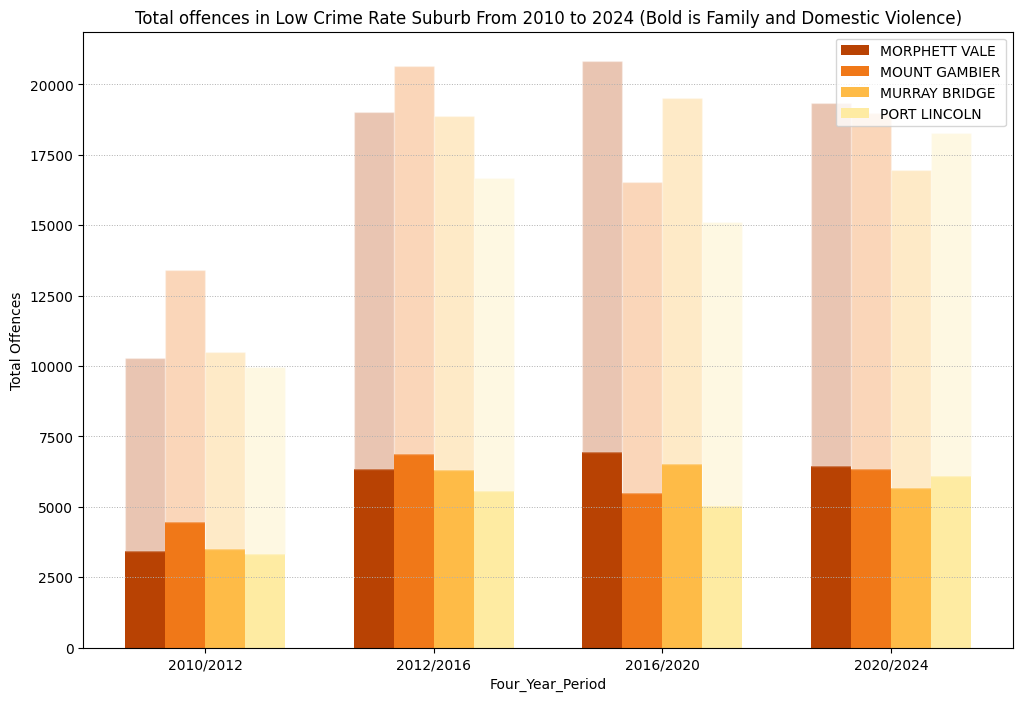

In [56]:
analysis_domestic_simple_compare(df_sa_good, df_fam_good, note='Low Crime Rate Suburb', color_palette='YlOrBr')

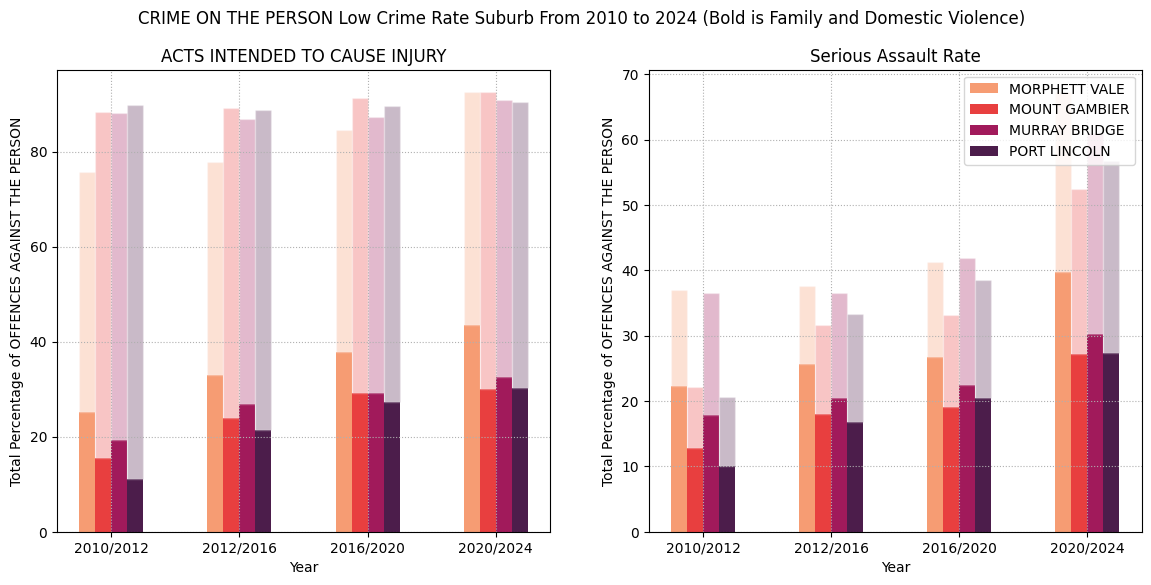

In [57]:
person_analysis_compare(df_sa_good, df_fam_good, note='Low Crime Rate Suburb', color_palette='rocket')

In general, there is a sightly increase in the number of domestic violence cases. However, the intensity of the crime is what the should notice. The proportion of family and Domestic Violence start to get larger from under 20% in 2010 to more than 30% in 2024. Beside Morphet Vale, most suburn has relatively similar proportion figue

Moreover, most of family and Domestic Violence are Serious Assault, as the proportion only decrease from 5 to at most 10% of the total offence on person. Serious Assault of Domestic Violence itself took acount for more than have of total
serious assault cases.

### Bad Suburb

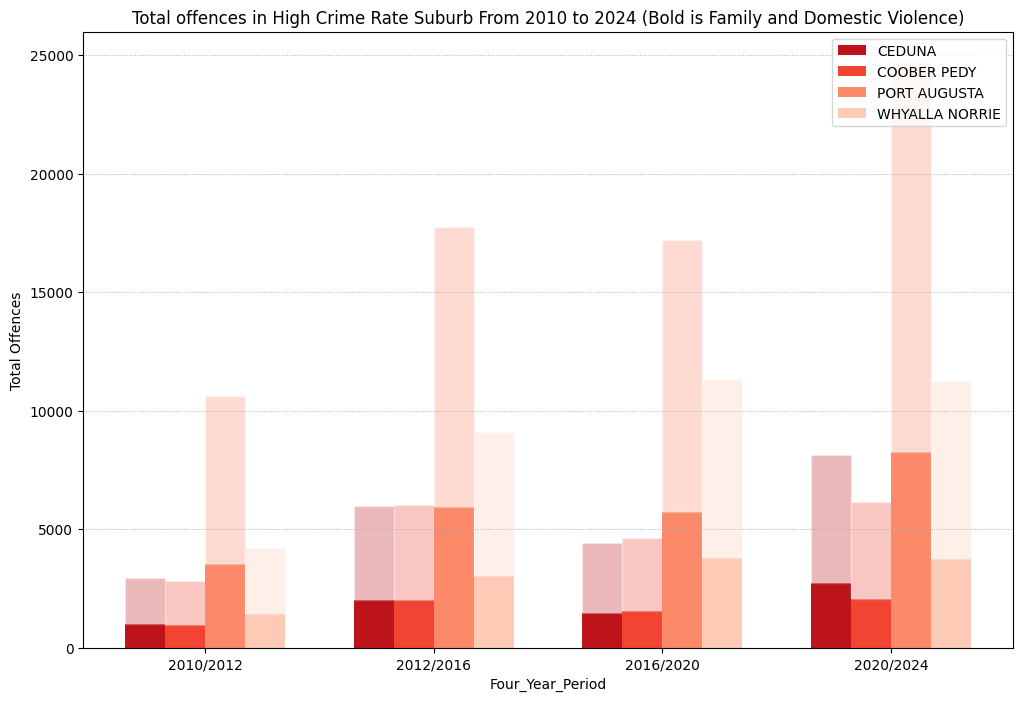

In [58]:
analysis_domestic_simple_compare(df_sa_bad, df_fam_bad, note='High Crime Rate Suburb', color_palette='Reds')

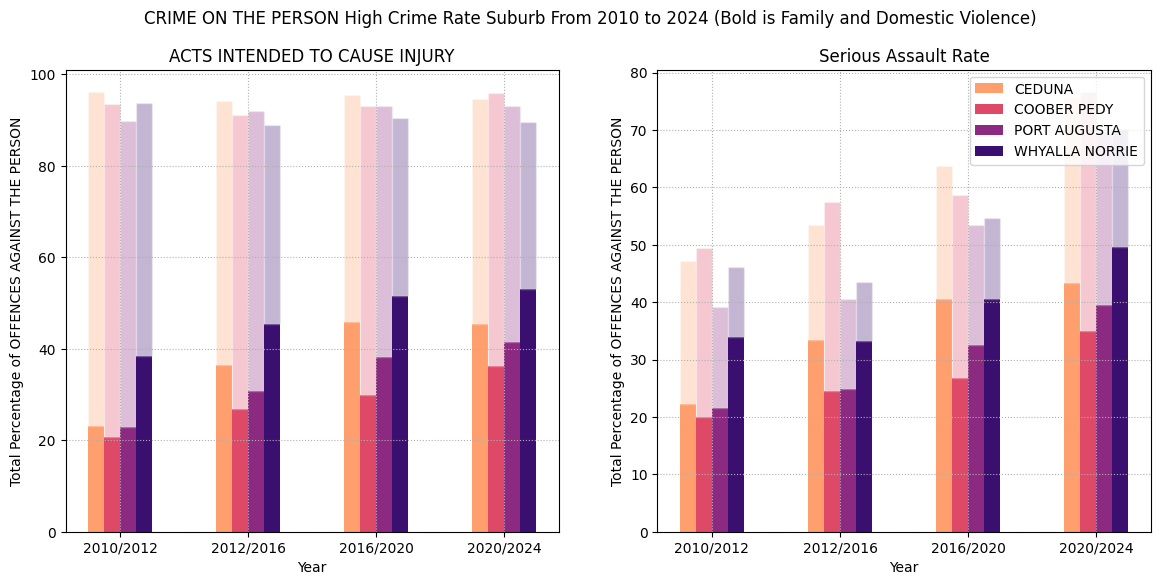

In [59]:
person_analysis_compare(df_sa_bad, df_fam_bad, note='High Crime Rate Suburb', color_palette='magma')

With "bad" suburbs, we do also observe the same trend where there is a sightly increase in the number of family and domestic violence, and the intensity of it has became worse over the year. However, the proportion of serious assault in these neighbour are around 5-10 point higher than the good onces, with WHYALLA NORRIE peaked at 50% of all crimes on person and 70% of total serious assault.

It is suprising that WHYALLA NORRIE, a neighbour that has an accecptable statistic in preivous sections, has now lead in the percentage of serious assault in domestic violent. By contrast, COOBER PEDY, a dangerous suburb has a relatively low propotion of domestic violence in comparison with other "bad" suburbs and close to MORPHET VALE, a nice suburbs.

## 5. Conclusion

This analysis offered a closer look at crime patterns in various Australian suburbs over the past few years, bringing several key points to light:

**Overall Crime Stability with Shifting Trends:** Although the overall crime rate has stayed relatively steady, the types of crimes have shifted. While property crimes have declined, crimes targeting individuals, particularly assaults, have been on the rise.

**Increase in Serious Assaults:** Serious assault cases have notably increased, which impacts community safety and calls for a proactive approach to resource allocation. While familys and murders have decreased, the ongoing high rate of serious crimes and sexual offenses is still a concern.

**Domestic Violence** Cross-referencing with domestic violence data revealed high rates in recent years. This insight is vital for policy-making and prevention efforts, especially given the sensitive nature of these crimes and their impact on communities.

**Best suburb to live in** Based on selected suburbs, MOUNT GAMBIER and MURRAY BRIDGE are the good place to live. By contrast, CENUDA, COOBER PEDY and WHYALLA are the suburbs should be carefully evaluated before moving here.

**Looking Ahead – What Can Be Done?:** Addressing these crime trends calls for a combination of local initiatives and broader policies. Our findings suggest that targeted actions—like increasing police presence, supporting community programs, and enhancing preventive education—might make a difference, especially in areas with higher crime rates.

Overall, this analysis provides a useful foundation for understanding Australian crime trends. These insights could help shape strategies that make communities safer and tackle crime where it’s most needed.

# III. Solution